## Workflow
1. Understand the Dreaddit dataset through some Exploratory Data Analysis
2. Finetune BERT model for prediction of stress label
3. Evaluate model performance based on F1 score
4. Perform 3 analysis to uncover insights

In [1]:
import os
import string
import re
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from datasets import Dataset
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, logging
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Load the Dreaddit dataset
This dataset contains Reddit posts from 10 subreddits in the five domains:
  1. Abuse (domesticviolence, survivorsofabuse)
  2. Social (relationships)
  3. Anxiety (anxiety, stress)
  4. PTSD (ptsd)
  5. Financial (almosthomeless, assistance, food_pantry, homeless)

In [2]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Load training data
file_path = "dreaddit-train.csv"
train_df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "rishantenis/dreaddit-train-test",
  file_path
)

# Load test data
file_path = "dreaddit-test.csv"
test_df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "rishantenis/dreaddit-train-test",
  file_path
)

/tmp/ipython-input-2976173939.py:6: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  train_df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'dreaddit-train-test' dataset.


/tmp/ipython-input-2976173939.py:14: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  test_df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'dreaddit-train-test' dataset.


In [3]:
# Examine the dataset
print(train_df.info())
# Conclusion: There are 2838 entries with 116 columns in training dataset.
print(test_df.info())
# Conclusion: There are 715 entries with 116 columns in test dataset.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Columns: 116 entries, subreddit to sentiment
dtypes: float64(106), int64(6), object(4)
memory usage: 2.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Columns: 116 entries, id to sentiment
dtypes: float64(107), int64(5), object(4)
memory usage: 648.1+ KB
None


### Data cleaning

In [4]:
# Check for null values
print(train_df.isnull().sum().sum())
print(test_df.isnull().sum().sum())
# Conclusion: There are no null values

0
0


In [5]:
# Drop columns regarding liwc, and other irrelevant columns
print(f'Original number of columns: {len(train_df.columns)}')
columns_to_drop = [col for col in train_df.columns if 'lex' in col]
columns_to_drop += ['post_id', 'sentence_range', 'id', 'social_timestamp']
train_df2 = train_df.drop(columns=columns_to_drop)
test_df2 = test_df.drop(columns=columns_to_drop)

# Rename label column
train_df2 = train_df2.rename(columns={'label': 'stress'})
test_df2 = test_df2.rename(columns={'label': 'stress'})

print(f'Updated number of columns: {len(train_df2.columns)}')
print(f'Columns:\n{train_df2.columns}')

Original number of columns: 116
Updated number of columns: 10
Columns:
Index(['subreddit', 'text', 'stress', 'confidence', 'social_karma',
       'syntax_ari', 'social_upvote_ratio', 'social_num_comments',
       'syntax_fk_grade', 'sentiment'],
      dtype='object')


The remaining columns are:
- subreddit (the subreddit the post belongs to)
- text (contents of the post)
- stress (binary label, stress = 1 and no stress = 0)
- confidence (confidence score in stress labels ranging from 0 to 1)
- social_karma (Number of upvotes - Number of downvotes)
- syntax_ari (Automated Readibility Index)
- social_upvote_ratio (Ratio of upvotes to total votes)
- socal_num_comments (Number of comments)
- syntax_fk_grade (Flesch–Kincaid grade level)
- sentiment (Sentiment polarity score ranging from -1 to 1)

** Note that Automated Readibility Index and Flesch–Kincaid grade level are measures of readibility of the text

In [6]:
# Clean text data
def clean_text(text):
    text = re.sub(r'\b\S*r/\S*\b', '', text) # Remove words containing 'r/' as these refer to subreddits
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"[^\w\s]", "", text) # Remove all punctuation and special characters
    return text

train_df2['cleaned_text'] = train_df2['text'].apply(clean_text)
test_df2['cleaned_text'] = test_df2['text'].apply(clean_text)
print(train_df2[['text', 'cleaned_text']].head())

                                                text  \
0  He said he had not felt that way before, sugge...   
1  Hey there r/assistance, Not sure if this is th...   
2  My mom then hit me with the newspaper and it s...   
3  until i met my new boyfriend, he is amazing, h...   
4  October is Domestic Violence Awareness Month a...   

                                        cleaned_text  
0  he said he had not felt that way before sugget...  
1  hey there  not sure if this is the right place...  
2  my mom then hit me with the newspaper and it s...  
3  until i met my new boyfriend he is amazing he ...  
4  october is domestic violence awareness month a...  


In [7]:
# Word tokenize the text data
train_df2['tokens'] = train_df2['cleaned_text'].apply(nltk.word_tokenize)
test_df2['tokens'] = test_df2['cleaned_text'].apply(nltk.word_tokenize)

# Remove common stop words from text data
stop_words = set(stopwords.words('english'))
train_df2['tokens'] = train_df2['tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])
test_df2['tokens'] = test_df2['tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])
print(train_df2[['cleaned_text', 'tokens']].head())

                                        cleaned_text  \
0  he said he had not felt that way before sugget...   
1  hey there  not sure if this is the right place...   
2  my mom then hit me with the newspaper and it s...   
3  until i met my new boyfriend he is amazing he ...   
4  october is domestic violence awareness month a...   

                                              tokens  
0  [said, felt, way, suggeted, go, rest, trigger,...  
1  [hey, sure, right, place, post, goes, im, curr...  
2  [mom, hit, newspaper, shocked, would, knows, d...  
3  [met, new, boyfriend, amazing, kind, sweet, go...  
4  [october, domestic, violence, awareness, month...  


### Exploratory data analysis

In [8]:
# Examine distribution of labels (stress vs no stress)
print("Distribution of labels: ")
print(train_df2['stress'].value_counts())
print("\nDistribution of labels in %: ")
print(train_df2['stress'].value_counts(normalize=True) * 100)
# Conclusion: The dataset has a relatively balanced distribution of stress (label 1) and no-stress (label 0) entries.

Distribution of labels: 
stress
1    1488
0    1350
Name: count, dtype: int64

Distribution of labels in %: 
stress
1    52.43129
0    47.56871
Name: proportion, dtype: float64


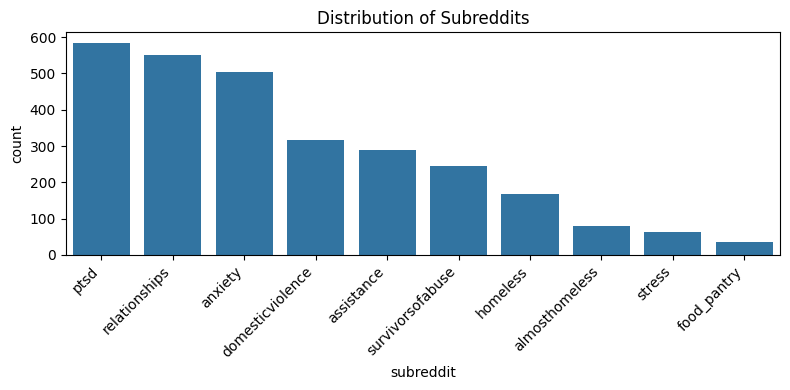

In [9]:
# Examine distribution of Reddit posts from the different subreddits
plt.figure(figsize=(8, 4))
sns.countplot(data=train_df2, x='subreddit', order=train_df2['subreddit'].value_counts().index)
plt.title('Distribution of Subreddits')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
# Conclusion: We have plenty of data from some subreddits, but few for other subreddits (especially for subreddits in the financial domain).
# May potentially negatively affect performance of model for those subreddits with little data.

In [10]:
# Look at the top 10 most common words in stressed and non-stressed entries
# Do note stop words have been removed for this analysis
stressed_df = train_df2[train_df2['stress'] == 1]
non_stressed_df = train_df2[train_df2['stress'] == 0]

all_stressed_words = [word for sublist in stressed_df['tokens'] for word in sublist]
all_non_stressed_words = [word for sublist in non_stressed_df['tokens'] for word in sublist]

stressed_word_freq = Counter(all_stressed_words)
non_stressed_word_freq = Counter(all_non_stressed_words)
top_10_stressed_words = stressed_word_freq.most_common(10)
top_10_non_stressed_words = non_stressed_word_freq.most_common(10)

total_stressed_words = sum(stressed_word_freq.values())
total_non_stressed_words = sum(non_stressed_word_freq.values())

print("Top 10 most common words in stressed entries:")
for word, count in top_10_stressed_words:
    percentage = (count / total_stressed_words) * 100
    print(f"- {word}: {count} ({percentage:.2f}%)")
print("\nTop 10 most common words in non-stressed entries:")
for word, count in top_10_non_stressed_words:
    percentage = (count / total_non_stressed_words) * 100
    print(f"- {word}: {count} ({percentage:.2f}%) ")

Top 10 most common words in stressed entries:
- im: 1259 (2.03%)
- like: 756 (1.22%)
- dont: 649 (1.05%)
- feel: 575 (0.93%)
- know: 548 (0.88%)
- get: 517 (0.83%)
- ive: 442 (0.71%)
- even: 426 (0.69%)
- time: 408 (0.66%)
- really: 373 (0.60%)

Top 10 most common words in non-stressed entries:
- im: 508 (0.95%) 
- would: 431 (0.81%) 
- like: 425 (0.80%) 
- time: 349 (0.65%) 
- get: 335 (0.63%) 
- know: 308 (0.58%) 
- dont: 285 (0.53%) 
- really: 277 (0.52%) 
- one: 276 (0.52%) 
- people: 248 (0.46%) 


Notice that both types of entries have very similar common words appearing. Hence, the main distinguishing factor between the two types of entries is not the vocabulary, but the frequency of these words being used. So stress is likely reflected in distribution shifts, not completely different vocabulary.

We note that there are slightly more stressed entries (1488) in the dataset than non-stressed entries (1350). Hence instead of comparing the word count directly, we will compare the percentage of common words appearing in the entries.

- One interesting thing to note is that "im" is the most common word for both types of entries. However, the number of occurrences of the word "im" in stressed entries (2.03%) is double that of non-stressed entries (0.95%). The word "ive" - meaning "I have" - is also one of the most common words in stressed entries. All of these facts indicates that stressed entries tend to have more self-referential language using the pronoun "I".

- On the other hand "people" is a common word in non-stressed entries, indicating that non-stressed entries are perhaps more outward looking and sociable.

- Another point of interest is that the word "feel" is a common word in stressed entries. This suggests emotional expression is more prominent in stressed entries.

In [11]:
# Look at top 10 bigrams for stressed and non-stressed entries
# Note that stop words have been removed for this analysis
all_stressed_bigrams = [bigram for sublist in stressed_df['tokens'] for bigram in list(nltk.bigrams(sublist))]
all_non_stressed_bigrams = [bigram for sublist in non_stressed_df['tokens'] for bigram in list(nltk.bigrams(sublist))]

stressed_bigram_freq = Counter(all_stressed_bigrams)
non_stressed_bigram_freq = Counter(all_non_stressed_bigrams)
top_10_stressed_bigrams = stressed_bigram_freq.most_common(10)
top_10_non_stressed_bigrams = non_stressed_bigram_freq.most_common(10)

total_stressed_bigrams = sum(stressed_bigram_freq.values())
total_non_stressed_bigrams = sum(non_stressed_bigram_freq.values())

print("Top 10 most common bigrams in stressed entries:")
for bigram, count in top_10_stressed_bigrams:
    percentage = (count / total_stressed_bigrams) * 100
    print(f"- {bigram[0]} {bigram[1]}: {count} ({percentage:.2f}%)")

print("\nTop 10 most common bigrams in non-stressed entries:")
for bigram, count in top_10_non_stressed_bigrams:
    percentage = (count / total_non_stressed_bigrams) * 100
    print(f"- {bigram[0]} {bigram[1]}: {count} ({percentage:.2f}%)")

Top 10 most common bigrams in stressed entries:
- feel like: 228 (0.38%)
- dont know: 206 (0.34%)
- dont want: 83 (0.14%)
- like im: 58 (0.10%)
- im going: 45 (0.07%)
- anyone else: 43 (0.07%)
- panic attacks: 40 (0.07%)
- even though: 40 (0.07%)
- im scared: 38 (0.06%)
- im trying: 38 (0.06%)

Top 10 most common bigrams in non-stressed entries:
- feel like: 60 (0.12%)
- mental health: 48 (0.09%)
- dont want: 44 (0.08%)
- dont know: 43 (0.08%)
- years ago: 39 (0.07%)
- first time: 35 (0.07%)
- would like: 33 (0.06%)
- let know: 28 (0.05%)
- year old: 26 (0.05%)
- im going: 25 (0.05%)


In addition to the analysis done on the most common words in stressed and non-stressed entries, we also identify the top 10 most common bigrams for analysis.

- One point of interest is the bigrams containing the pronoun "I" ("im going", "im scared", "im trying"). From the word count analysis done above, we have established that the pronoun "I" appears frequently in both types of entries, yet we can see that the context in which the word "im" appears is quite different between stressed and non-stressed entries. We have "im scared" and "im trying" appearing commonly in stressed entries which are not in non-stressed entries. These phrases are tied to feelings of distress and helplessness.

- Another interesting thing to note is that the bigram "dont know" appears frequently in both types of entries, but "dont know" is 4 times more common in stressed entries than non-stressed entries. "dont know" is a phrase associated with uncertainty and helplessness to a certain extent, and these feelings appear to be correlated to stress.

- Common bigrams like "panic attacks" and "im scared" clearly indicates that stressed entries are very emotionally charged. This is futher supported by the fact that "feel like" is 3 times more common in stressed entries than non-stressed entries.

- On the other hand, in non-stressed entries, we have common bigrams like "years ago", "year old" and "first time" which are descriptive and narrative phrases, almost like storytelling.

Conclusion:
Stress entries are characterized by uncertainty, fear, and emotional self-processing, while non-stressed entries are more informational and narrative.

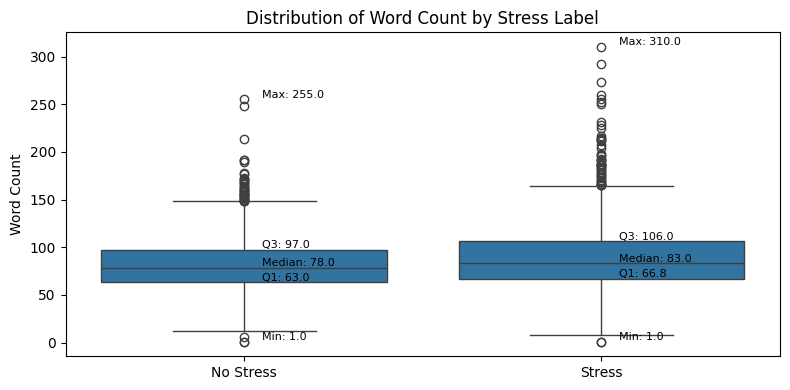

In [12]:
# Examine distribution of word count between stress and non-stress entries
train_df2['word_count'] = train_df2['text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8, 4))
sns.boxplot(data=train_df2, x='stress', y='word_count', legend=False)
plt.title('Distribution of Word Count by Stress Label')
plt.xlabel('')
plt.ylabel('Word Count')
plt.xticks([0, 1], ['No Stress', 'Stress'])

# Annotate statistics on the actual lines
labels = sorted(train_df2['stress'].unique())
for i, label in enumerate(labels):
    subset = train_df2[train_df2['stress'] == label]['word_count']
    stats = {
        'Min': subset.min(),
        'Q1': subset.quantile(0.25),
        'Median': subset.median(),
        'Q3': subset.quantile(0.75),
        'Max': subset.max()
    }
    x_pos = i + 0.05
    for stat_name, y_val in stats.items():
        plt.text(
            x=x_pos,
            y=y_val + 5,
            s=f'{stat_name}: {y_val:.1f}',
            va='center',
            ha='left',
            fontsize=8,
            color='black'
        )

plt.tight_layout()
plt.show()
# Conclusion: Entries with stress have a slightly higher word count.

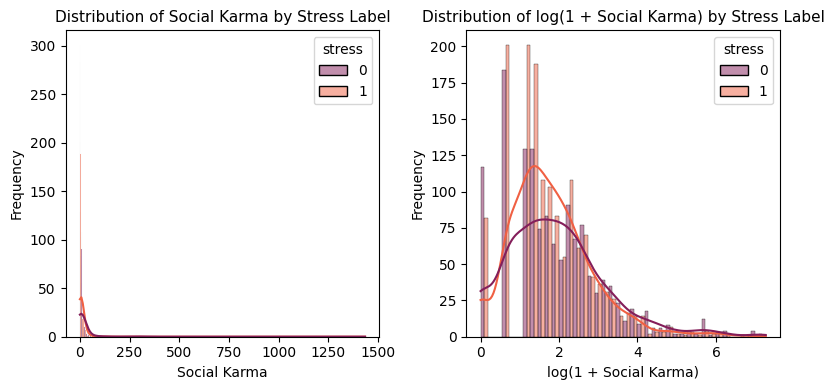

In [13]:
# Examine distribution of social karma between stress and non-stress entries
# Social karma = Number of upvotes - Number of downvotes

plt.figure(figsize=(8, 4))

# Plot 1: Social Karma
plt.subplot(1, 2, 1)
sns.histplot(data=train_df2, x='social_karma', hue='stress', kde=True, palette='rocket', multiple='dodge')
plt.title('Distribution of Social Karma by Stress Label', fontsize=11)
plt.xlabel('Social Karma')
plt.ylabel('Frequency')

# Plot 2: Social Karma with log1p transformation
plt.subplot(1, 2, 2)
plot_df = train_df2.copy()
plot_df['social_karma_log'] = np.log1p(plot_df['social_karma'])
sns.histplot(data=plot_df, x='social_karma_log', hue='stress', kde=True, palette='rocket', multiple='dodge')
plt.title('Distribution of log(1 + Social Karma) by Stress Label', fontsize=11)
plt.xlabel('log(1 + Social Karma)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
# Conclusion: Entries with stress are more associated with lower social karma.
# However, do note there are 1488-1350=138 more entries with stress than non-stress.
# Also note all entries have non-negative karma, meaning all entries have more upvotes than downvotes.

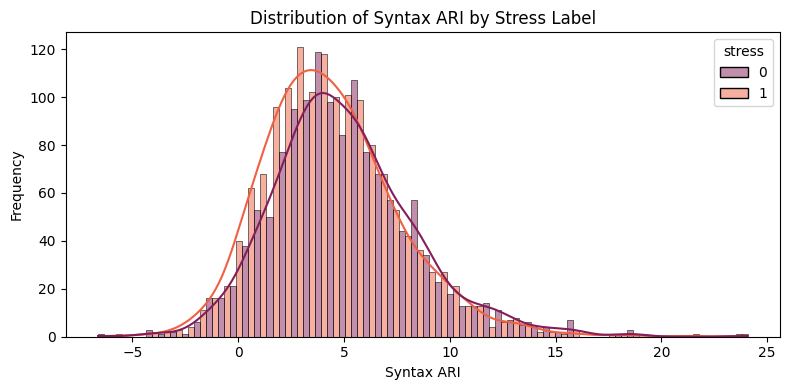

In [14]:
# Examine distribution of Automated Readibility Index between stress and non-stress entries
plt.figure(figsize=(8, 4))
sns.histplot(data=train_df2, x='syntax_ari', hue='stress', kde=True, palette='rocket', multiple='dodge')
plt.title('Distribution of Syntax ARI by Stress Label')
plt.xlabel('Syntax ARI')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()
# Conclusion: Entries with stress are slightly more associated with lower ARI score, meaning less readable.

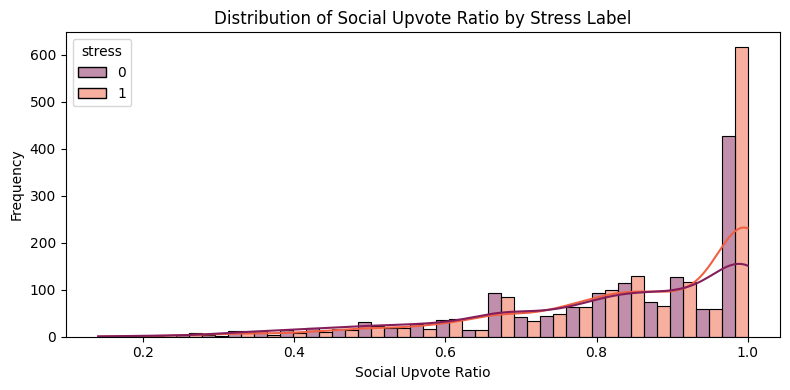

In [15]:
# Examine distribution of social upvote ratio between stress and non-stress entries
plt.figure(figsize=(8, 4))
sns.histplot(data=train_df2, x='social_upvote_ratio', hue='stress', kde=True, palette='rocket', multiple='dodge')
plt.title('Distribution of Social Upvote Ratio by Stress Label')
plt.xlabel('Social Upvote Ratio')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()
# Conclusion: There does not appear significant relationship between stress and social upvote ratio.

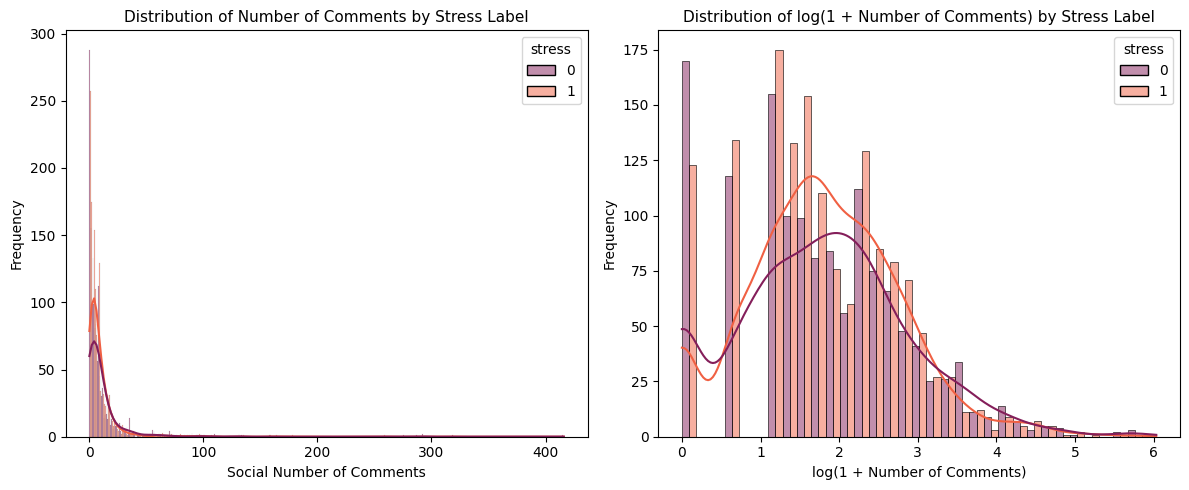

In [16]:
# Examine distribution of number of comments between stress and non-stress entries

plt.figure(figsize=(12, 5))

# Plot 1: Number of Comments without log transformation
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
sns.histplot(data=train_df2, x='social_num_comments', hue='stress', kde=True, palette='rocket', multiple='dodge')
plt.title('Distribution of Number of Comments by Stress Label', fontsize=11)
plt.xlabel('Social Number of Comments')
plt.ylabel('Frequency')

# Plot 2: Number of Comments with log1p transformation
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
plot_df = train_df2.copy()
plot_df['social_num_comments_log'] = np.log1p(plot_df['social_num_comments'])
sns.histplot(data=plot_df, x='social_num_comments_log', hue='stress', kde=True, palette='rocket', multiple='dodge')
plt.title('Distribution of log(1 + Number of Comments) by Stress Label', fontsize=11)
plt.xlabel('log(1 + Number of Comments)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
# Conclusion: There appears to be fewer comments for entries with stress.

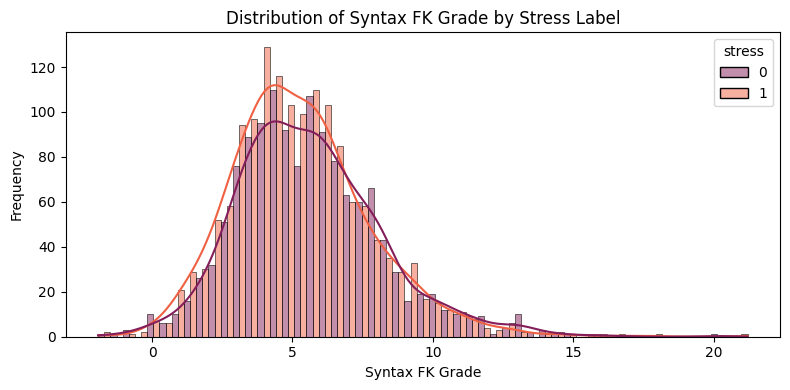

In [17]:
# Examine distribution of Flesch-Kincaid Grade level between stress and non-stress entries
plt.figure(figsize=(8, 4))
sns.histplot(data=train_df2, x='syntax_fk_grade', hue='stress', kde=True, palette='rocket', multiple='dodge')
plt.title('Distribution of Syntax FK Grade by Stress Label')
plt.xlabel('Syntax FK Grade')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()
# Conclusion: Entries with stress are slightly more associated with lower FK Grade, meaning less readable.

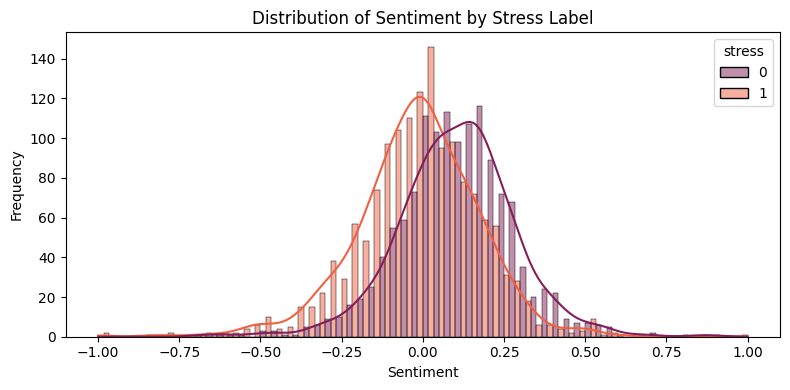

In [18]:
# Examine distribution of sentiment between stress and non-stress entries
plt.figure(figsize=(8, 4))
sns.histplot(data=train_df2, x='sentiment', hue='stress', kde=True, palette='rocket', multiple='dodge')
plt.title('Distribution of Sentiment by Stress Label')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()
# Conclusion: Entries with stress tend to have a lower (more negative) sentiment score compared to entries without stress.

### Finetuning DistilBERT model

In [ ]:
# Prepare the datasets
train_df = train_df2.sample(frac=0.8, random_state=42)
val_df = train_df2.drop(train_df.index)
test_df = test_df2

print(f'Training set size: {len(train_df)}')
print(f'Validation set size: {len(val_df)}')
print(f'Test set size: {len(test_df)}')

Training set size: 2270
Validation set size: 568
Test set size: 715


In [ ]:
# Load pretrained distilbert model and tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name) # will have to use the tokenizer that comes with the pretrained distilbert model to ensure compatibility
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.bias     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [ ]:
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True)

# The 'stress' column needs to be renamed to 'label' for Hugging Face Trainer
train_df = train_df.rename(columns={'stress': 'label'})
val_df = val_df.rename(columns={'stress': 'label'})
test_df = test_df.rename(columns={'stress': 'label'})
# Convert pandas DataFrames to Hugging Face Dataset objects
new_train_df = Dataset.from_pandas(train_df)
new_val_df = Dataset.from_pandas(val_df)
new_test_df = Dataset.from_pandas(test_df)

tokenized_train_df = new_train_df.map(tokenize_function, batched=True)
tokenized_val_df = new_val_df.map(tokenize_function, batched=True)
tokenized_test_df = new_test_df.map(tokenize_function, batched=True)

Map:   0%|          | 0/2270 [00:00<?, ? examples/s]

Map:   0%|          | 0/568 [00:00<?, ? examples/s]

Map:   0%|          | 0/715 [00:00<?, ? examples/s]

In [ ]:
# Define metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

Perform hyperparameter tuning

In [ ]:
!pip install optuna --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 30.2 MB/s eta 0:00:00


In [ ]:
# DO NOT RUN unless necessary. Will take a while to run.
# Use optuna library to find best set of hyperparameters
import optuna

data_collator = DataCollatorWithPadding(tokenizer=tokenizer) # add padding so all posts are of equal length
logging.set_verbosity_error() # to disable display of logs
kf = KFold(n_splits=5, shuffle=True, random_state=42) # 5-fold cross validation

def objective(trial, kf):
    # Define the hyperparameter search space
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    weight_decay = trial.suggest_float("weight_decay", 0.001, 0.01, log=True)

    f1_scores = []

    for fold, (train_index, val_index) in enumerate(kf.split(tokenized_train_df)):
        # Create training and validation datasets for the current fold
        fold_train_dataset = tokenized_train_df.select(train_index)
        fold_val_dataset = tokenized_train_df.select(val_index)

        # Define new model for each fold to prevent weights leakage
        model_cv = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

        # Define a unique output directory for each trial and fold
        output_dir = f"./{model_name}_finetuned_trial_{trial.number}_fold_{fold}"
        os.makedirs(output_dir, exist_ok=True)

        # Configure TrainingArguments for the current fold
        training_args_cv = TrainingArguments(
            output_dir=f"./results_trial_{trial.number}_fold_{fold}",
            eval_strategy="epoch",
            learning_rate=learning_rate,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            num_train_epochs=2,
            weight_decay=weight_decay,
            fp16=True,
            save_strategy="no",
            disable_tqdm=True,
            report_to="none",
            seed=42 + fold # Vary seed slightly for each fold for robustness
        )

        # Initialize Trainer and train model for the current fold
        trainer_cv = Trainer(
            model=model_cv,
            args=training_args_cv,
            compute_metrics=compute_metrics,
            train_dataset=fold_train_dataset,
            eval_dataset=fold_val_dataset,
            data_collator=data_collator
        )
        trainer_cv.train()

        # Evaluate the model and append validation f1-score
        eval_results_cv = trainer_cv.evaluate()
        f1_scores.append(eval_results_cv["eval_f1"])

    # Calculate and return the average F1-score across all folds
    avg_f1 = sum(f1_scores) / len(f1_scores)
    return avg_f1

# Try 10 different sets of hyperparameters to find the best combination with highest f1-score
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, kf), n_trials=10)

print("\nBest hyperparameters:", study.best_params)
print("Best F1-score:", study.best_value)


[I 2026-02-25 11:29:57,859] A new study created in memory with name: no-name-83dad1f5-b94f-46f0-98d9-00c01ea2cf8e


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4405', 'eval_accuracy': '0.8084', 'eval_f1': '0.8075', 'eval_runtime': '0.6977', 'eval_samples_per_second': '650.7', 'eval_steps_per_second': '41.57', 'epoch': '1'}
{'eval_loss': '0.4407', 'eval_accuracy': '0.8084', 'eval_f1': '0.8083', 'eval_runtime': '0.7736', 'eval_samples_per_second': '586.9', 'eval_steps_per_second': '37.49', 'epoch': '2'}
{'train_runtime': '22.25', 'train_samples_per_second': '163.2', 'train_steps_per_second': '10.25', 'train_loss': '0.45', 'epoch': '2'}
{'eval_loss': '0.4407', 'eval_accuracy': '0.8084', 'eval_f1': '0.8083', 'eval_runtime': '0.7003', 'eval_samples_per_second': '648.3', 'eval_steps_per_second': '41.41', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4079', 'eval_accuracy': '0.8238', 'eval_f1': '0.8237', 'eval_runtime': '0.7658', 'eval_samples_per_second': '592.8', 'eval_steps_per_second': '37.87', 'epoch': '1'}
{'eval_loss': '0.4006', 'eval_accuracy': '0.826', 'eval_f1': '0.8257', 'eval_runtime': '0.6937', 'eval_samples_per_second': '654.4', 'eval_steps_per_second': '41.8', 'epoch': '2'}
{'train_runtime': '20.26', 'train_samples_per_second': '179.2', 'train_steps_per_second': '11.25', 'train_loss': '0.4491', 'epoch': '2'}
{'eval_loss': '0.4006', 'eval_accuracy': '0.826', 'eval_f1': '0.8257', 'eval_runtime': '0.7228', 'eval_samples_per_second': '628.1', 'eval_steps_per_second': '40.12', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4379', 'eval_accuracy': '0.8216', 'eval_f1': '0.8188', 'eval_runtime': '0.6886', 'eval_samples_per_second': '659.3', 'eval_steps_per_second': '42.11', 'epoch': '1'}
{'eval_loss': '0.4313', 'eval_accuracy': '0.8238', 'eval_f1': '0.8215', 'eval_runtime': '0.6967', 'eval_samples_per_second': '651.6', 'eval_steps_per_second': '41.62', 'epoch': '2'}
{'train_runtime': '20.83', 'train_samples_per_second': '174.4', 'train_steps_per_second': '10.95', 'train_loss': '0.4459', 'epoch': '2'}
{'eval_loss': '0.4313', 'eval_accuracy': '0.8238', 'eval_f1': '0.8215', 'eval_runtime': '0.6868', 'eval_samples_per_second': '661', 'eval_steps_per_second': '42.23', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4575', 'eval_accuracy': '0.7819', 'eval_f1': '0.7765', 'eval_runtime': '0.6897', 'eval_samples_per_second': '658.2', 'eval_steps_per_second': '42.05', 'epoch': '1'}
{'eval_loss': '0.4298', 'eval_accuracy': '0.804', 'eval_f1': '0.803', 'eval_runtime': '0.6888', 'eval_samples_per_second': '659.1', 'eval_steps_per_second': '42.1', 'epoch': '2'}
{'train_runtime': '21.32', 'train_samples_per_second': '170.4', 'train_steps_per_second': '10.7', 'train_loss': '0.4565', 'epoch': '2'}
{'eval_loss': '0.4298', 'eval_accuracy': '0.804', 'eval_f1': '0.803', 'eval_runtime': '0.6842', 'eval_samples_per_second': '663.6', 'eval_steps_per_second': '42.39', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4151', 'eval_accuracy': '0.8172', 'eval_f1': '0.817', 'eval_runtime': '0.6719', 'eval_samples_per_second': '675.7', 'eval_steps_per_second': '43.16', 'epoch': '1'}
{'eval_loss': '0.4069', 'eval_accuracy': '0.8238', 'eval_f1': '0.8237', 'eval_runtime': '0.675', 'eval_samples_per_second': '672.5', 'eval_steps_per_second': '42.96', 'epoch': '2'}
{'train_runtime': '22.25', 'train_samples_per_second': '163.2', 'train_steps_per_second': '10.25', 'train_loss': '0.4485', 'epoch': '2'}


[I 2026-02-25 11:31:55,813] Trial 0 finished with value: 0.8164631373202818 and parameters: {'learning_rate': 1.831761584578e-05, 'batch_size': 16, 'weight_decay': 0.004403922293915177}. Best is trial 0 with value: 0.8164631373202818.


{'eval_loss': '0.4069', 'eval_accuracy': '0.8238', 'eval_f1': '0.8237', 'eval_runtime': '0.6674', 'eval_samples_per_second': '680.2', 'eval_steps_per_second': '43.45', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4402', 'eval_accuracy': '0.8216', 'eval_f1': '0.8207', 'eval_runtime': '0.7487', 'eval_samples_per_second': '606.4', 'eval_steps_per_second': '38.73', 'epoch': '1'}
{'eval_loss': '0.4343', 'eval_accuracy': '0.7996', 'eval_f1': '0.7997', 'eval_runtime': '0.7465', 'eval_samples_per_second': '608.1', 'eval_steps_per_second': '38.85', 'epoch': '2'}
{'train_runtime': '21.91', 'train_samples_per_second': '165.7', 'train_steps_per_second': '10.4', 'train_loss': '0.4568', 'epoch': '2'}
{'eval_loss': '0.4343', 'eval_accuracy': '0.7996', 'eval_f1': '0.7997', 'eval_runtime': '0.7277', 'eval_samples_per_second': '623.9', 'eval_steps_per_second': '39.85', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.412', 'eval_accuracy': '0.8172', 'eval_f1': '0.817', 'eval_runtime': '0.7314', 'eval_samples_per_second': '620.7', 'eval_steps_per_second': '39.65', 'epoch': '1'}
{'eval_loss': '0.4', 'eval_accuracy': '0.8238', 'eval_f1': '0.8235', 'eval_runtime': '0.7237', 'eval_samples_per_second': '627.3', 'eval_steps_per_second': '40.07', 'epoch': '2'}
{'train_runtime': '21.59', 'train_samples_per_second': '168.2', 'train_steps_per_second': '10.56', 'train_loss': '0.4569', 'epoch': '2'}
{'eval_loss': '0.4', 'eval_accuracy': '0.8238', 'eval_f1': '0.8235', 'eval_runtime': '0.7253', 'eval_samples_per_second': '626', 'eval_steps_per_second': '39.98', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4464', 'eval_accuracy': '0.815', 'eval_f1': '0.8118', 'eval_runtime': '0.718', 'eval_samples_per_second': '632.3', 'eval_steps_per_second': '40.39', 'epoch': '1'}
{'eval_loss': '0.4326', 'eval_accuracy': '0.8216', 'eval_f1': '0.8196', 'eval_runtime': '0.7275', 'eval_samples_per_second': '624.1', 'eval_steps_per_second': '39.86', 'epoch': '2'}
{'train_runtime': '21.79', 'train_samples_per_second': '166.7', 'train_steps_per_second': '10.46', 'train_loss': '0.4574', 'epoch': '2'}
{'eval_loss': '0.4326', 'eval_accuracy': '0.8216', 'eval_f1': '0.8196', 'eval_runtime': '0.7256', 'eval_samples_per_second': '625.6', 'eval_steps_per_second': '39.96', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4692', 'eval_accuracy': '0.7797', 'eval_f1': '0.7726', 'eval_runtime': '0.7038', 'eval_samples_per_second': '645', 'eval_steps_per_second': '41.2', 'epoch': '1'}
{'eval_loss': '0.43', 'eval_accuracy': '0.8106', 'eval_f1': '0.8099', 'eval_runtime': '0.6996', 'eval_samples_per_second': '649', 'eval_steps_per_second': '41.45', 'epoch': '2'}
{'train_runtime': '21.79', 'train_samples_per_second': '166.7', 'train_steps_per_second': '10.46', 'train_loss': '0.4678', 'epoch': '2'}
{'eval_loss': '0.43', 'eval_accuracy': '0.8106', 'eval_f1': '0.8099', 'eval_runtime': '0.7031', 'eval_samples_per_second': '645.7', 'eval_steps_per_second': '41.25', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4256', 'eval_accuracy': '0.8062', 'eval_f1': '0.8058', 'eval_runtime': '0.6684', 'eval_samples_per_second': '679.2', 'eval_steps_per_second': '43.39', 'epoch': '1'}
{'eval_loss': '0.4101', 'eval_accuracy': '0.8326', 'eval_f1': '0.8325', 'eval_runtime': '0.6659', 'eval_samples_per_second': '681.8', 'eval_steps_per_second': '43.55', 'epoch': '2'}
{'train_runtime': '22.06', 'train_samples_per_second': '164.6', 'train_steps_per_second': '10.33', 'train_loss': '0.4609', 'epoch': '2'}


[I 2026-02-25 11:33:55,104] Trial 1 finished with value: 0.8170533197660049 and parameters: {'learning_rate': 1.6086699785789077e-05, 'batch_size': 16, 'weight_decay': 0.0022327518239252577}. Best is trial 1 with value: 0.8170533197660049.


{'eval_loss': '0.4101', 'eval_accuracy': '0.8326', 'eval_f1': '0.8325', 'eval_runtime': '0.6568', 'eval_samples_per_second': '691.3', 'eval_steps_per_second': '44.16', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4493', 'eval_accuracy': '0.8084', 'eval_f1': '0.8077', 'eval_runtime': '0.7483', 'eval_samples_per_second': '606.7', 'eval_steps_per_second': '38.75', 'epoch': '1'}
{'eval_loss': '0.4357', 'eval_accuracy': '0.804', 'eval_f1': '0.8038', 'eval_runtime': '0.7511', 'eval_samples_per_second': '604.4', 'eval_steps_per_second': '38.61', 'epoch': '2'}
{'train_runtime': '21.74', 'train_samples_per_second': '167', 'train_steps_per_second': '10.49', 'train_loss': '0.4827', 'epoch': '2'}
{'eval_loss': '0.4357', 'eval_accuracy': '0.804', 'eval_f1': '0.8038', 'eval_runtime': '0.745', 'eval_samples_per_second': '609.4', 'eval_steps_per_second': '38.92', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4297', 'eval_accuracy': '0.8128', 'eval_f1': '0.8125', 'eval_runtime': '0.7187', 'eval_samples_per_second': '631.7', 'eval_steps_per_second': '40.35', 'epoch': '1'}
{'eval_loss': '0.4106', 'eval_accuracy': '0.8238', 'eval_f1': '0.8236', 'eval_runtime': '0.8072', 'eval_samples_per_second': '562.5', 'eval_steps_per_second': '35.93', 'epoch': '2'}
{'train_runtime': '21.79', 'train_samples_per_second': '166.7', 'train_steps_per_second': '10.46', 'train_loss': '0.4768', 'epoch': '2'}
{'eval_loss': '0.4106', 'eval_accuracy': '0.8238', 'eval_f1': '0.8236', 'eval_runtime': '0.7498', 'eval_samples_per_second': '605.5', 'eval_steps_per_second': '38.68', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4632', 'eval_accuracy': '0.804', 'eval_f1': '0.7999', 'eval_runtime': '0.7669', 'eval_samples_per_second': '592', 'eval_steps_per_second': '37.82', 'epoch': '1'}
{'eval_loss': '0.4394', 'eval_accuracy': '0.8128', 'eval_f1': '0.8108', 'eval_runtime': '0.79', 'eval_samples_per_second': '574.7', 'eval_steps_per_second': '36.71', 'epoch': '2'}
{'train_runtime': '21.87', 'train_samples_per_second': '166', 'train_steps_per_second': '10.42', 'train_loss': '0.4865', 'epoch': '2'}
{'eval_loss': '0.4394', 'eval_accuracy': '0.8128', 'eval_f1': '0.8108', 'eval_runtime': '0.8004', 'eval_samples_per_second': '567.3', 'eval_steps_per_second': '36.23', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4708', 'eval_accuracy': '0.7797', 'eval_f1': '0.7734', 'eval_runtime': '0.7905', 'eval_samples_per_second': '574.3', 'eval_steps_per_second': '36.68', 'epoch': '1'}
{'eval_loss': '0.4387', 'eval_accuracy': '0.7952', 'eval_f1': '0.7947', 'eval_runtime': '0.7577', 'eval_samples_per_second': '599.2', 'eval_steps_per_second': '38.28', 'epoch': '2'}
{'train_runtime': '21.81', 'train_samples_per_second': '166.5', 'train_steps_per_second': '10.45', 'train_loss': '0.4935', 'epoch': '2'}
{'eval_loss': '0.4387', 'eval_accuracy': '0.7952', 'eval_f1': '0.7947', 'eval_runtime': '0.7831', 'eval_samples_per_second': '579.8', 'eval_steps_per_second': '37.03', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4516', 'eval_accuracy': '0.7952', 'eval_f1': '0.7949', 'eval_runtime': '0.7355', 'eval_samples_per_second': '617.3', 'eval_steps_per_second': '39.43', 'epoch': '1'}
{'eval_loss': '0.4229', 'eval_accuracy': '0.815', 'eval_f1': '0.815', 'eval_runtime': '0.6834', 'eval_samples_per_second': '664.3', 'eval_steps_per_second': '42.43', 'epoch': '2'}
{'train_runtime': '22.05', 'train_samples_per_second': '164.7', 'train_steps_per_second': '10.34', 'train_loss': '0.4947', 'epoch': '2'}


[I 2026-02-25 11:35:54,944] Trial 2 finished with value: 0.8095751568096746 and parameters: {'learning_rate': 1.188532971480547e-05, 'batch_size': 16, 'weight_decay': 0.0010445085602441566}. Best is trial 1 with value: 0.8170533197660049.


{'eval_loss': '0.4229', 'eval_accuracy': '0.815', 'eval_f1': '0.815', 'eval_runtime': '0.7562', 'eval_samples_per_second': '600.3', 'eval_steps_per_second': '38.35', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.444', 'eval_accuracy': '0.7996', 'eval_f1': '0.7998', 'eval_runtime': '0.8092', 'eval_samples_per_second': '561.1', 'eval_steps_per_second': '70.44', 'epoch': '1'}
{'eval_loss': '0.5215', 'eval_accuracy': '0.8128', 'eval_f1': '0.8127', 'eval_runtime': '0.7497', 'eval_samples_per_second': '605.6', 'eval_steps_per_second': '76.03', 'epoch': '2'}
{'train_runtime': '26.37', 'train_samples_per_second': '137.7', 'train_steps_per_second': '17.22', 'train_loss': '0.4005', 'epoch': '2'}
{'eval_loss': '0.5215', 'eval_accuracy': '0.8128', 'eval_f1': '0.8127', 'eval_runtime': '0.7254', 'eval_samples_per_second': '625.8', 'eval_steps_per_second': '78.57', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4075', 'eval_accuracy': '0.8172', 'eval_f1': '0.8159', 'eval_runtime': '0.7337', 'eval_samples_per_second': '618.8', 'eval_steps_per_second': '77.69', 'epoch': '1'}
{'eval_loss': '0.4338', 'eval_accuracy': '0.8304', 'eval_f1': '0.8302', 'eval_runtime': '0.7379', 'eval_samples_per_second': '615.3', 'eval_steps_per_second': '77.25', 'epoch': '2'}
{'train_runtime': '26.22', 'train_samples_per_second': '138.5', 'train_steps_per_second': '17.31', 'train_loss': '0.4028', 'epoch': '2'}
{'eval_loss': '0.4338', 'eval_accuracy': '0.8304', 'eval_f1': '0.8302', 'eval_runtime': '0.7168', 'eval_samples_per_second': '633.3', 'eval_steps_per_second': '79.52', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4549', 'eval_accuracy': '0.8018', 'eval_f1': '0.7973', 'eval_runtime': '0.7332', 'eval_samples_per_second': '619.2', 'eval_steps_per_second': '77.75', 'epoch': '1'}
{'eval_loss': '0.4991', 'eval_accuracy': '0.8018', 'eval_f1': '0.7994', 'eval_runtime': '0.7325', 'eval_samples_per_second': '619.8', 'eval_steps_per_second': '77.82', 'epoch': '2'}
{'train_runtime': '26.17', 'train_samples_per_second': '138.8', 'train_steps_per_second': '17.35', 'train_loss': '0.4189', 'epoch': '2'}
{'eval_loss': '0.4991', 'eval_accuracy': '0.8018', 'eval_f1': '0.7994', 'eval_runtime': '0.7121', 'eval_samples_per_second': '637.5', 'eval_steps_per_second': '80.04', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4421', 'eval_accuracy': '0.7952', 'eval_f1': '0.794', 'eval_runtime': '0.8366', 'eval_samples_per_second': '542.6', 'eval_steps_per_second': '68.13', 'epoch': '1'}
{'eval_loss': '0.4963', 'eval_accuracy': '0.8084', 'eval_f1': '0.8063', 'eval_runtime': '0.8458', 'eval_samples_per_second': '536.8', 'eval_steps_per_second': '67.39', 'epoch': '2'}
{'train_runtime': '26.42', 'train_samples_per_second': '137.5', 'train_steps_per_second': '17.18', 'train_loss': '0.4081', 'epoch': '2'}
{'eval_loss': '0.4963', 'eval_accuracy': '0.8084', 'eval_f1': '0.8063', 'eval_runtime': '0.8504', 'eval_samples_per_second': '533.9', 'eval_steps_per_second': '67.03', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4187', 'eval_accuracy': '0.8128', 'eval_f1': '0.8128', 'eval_runtime': '0.7081', 'eval_samples_per_second': '641.1', 'eval_steps_per_second': '80.5', 'epoch': '1'}
{'eval_loss': '0.4811', 'eval_accuracy': '0.8128', 'eval_f1': '0.8121', 'eval_runtime': '0.7072', 'eval_samples_per_second': '642', 'eval_steps_per_second': '80.6', 'epoch': '2'}
{'train_runtime': '26.4', 'train_samples_per_second': '137.6', 'train_steps_per_second': '17.2', 'train_loss': '0.4014', 'epoch': '2'}


[I 2026-02-25 11:38:17,071] Trial 3 finished with value: 0.8121405214219679 and parameters: {'learning_rate': 2.8005068055279125e-05, 'batch_size': 8, 'weight_decay': 0.0025914862707511525}. Best is trial 1 with value: 0.8170533197660049.


{'eval_loss': '0.4811', 'eval_accuracy': '0.8128', 'eval_f1': '0.8121', 'eval_runtime': '0.6943', 'eval_samples_per_second': '653.9', 'eval_steps_per_second': '82.09', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4654', 'eval_accuracy': '0.8062', 'eval_f1': '0.8044', 'eval_runtime': '0.8315', 'eval_samples_per_second': '546', 'eval_steps_per_second': '18.04', 'epoch': '1'}
{'eval_loss': '0.4412', 'eval_accuracy': '0.8084', 'eval_f1': '0.8075', 'eval_runtime': '0.8426', 'eval_samples_per_second': '538.8', 'eval_steps_per_second': '17.8', 'epoch': '2'}
{'train_runtime': '20.66', 'train_samples_per_second': '175.8', 'train_steps_per_second': '5.518', 'train_loss': '0.5052', 'epoch': '2'}
{'eval_loss': '0.4412', 'eval_accuracy': '0.8084', 'eval_f1': '0.8075', 'eval_runtime': '0.8284', 'eval_samples_per_second': '548', 'eval_steps_per_second': '18.11', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4644', 'eval_accuracy': '0.8018', 'eval_f1': '0.7996', 'eval_runtime': '0.7602', 'eval_samples_per_second': '597.2', 'eval_steps_per_second': '19.73', 'epoch': '1'}
{'eval_loss': '0.422', 'eval_accuracy': '0.8128', 'eval_f1': '0.8122', 'eval_runtime': '0.8269', 'eval_samples_per_second': '549', 'eval_steps_per_second': '18.14', 'epoch': '2'}
{'train_runtime': '20.66', 'train_samples_per_second': '175.8', 'train_steps_per_second': '5.517', 'train_loss': '0.495', 'epoch': '2'}
{'eval_loss': '0.422', 'eval_accuracy': '0.8128', 'eval_f1': '0.8122', 'eval_runtime': '0.8079', 'eval_samples_per_second': '562', 'eval_steps_per_second': '18.57', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.5179', 'eval_accuracy': '0.7621', 'eval_f1': '0.7505', 'eval_runtime': '0.8345', 'eval_samples_per_second': '544.1', 'eval_steps_per_second': '17.98', 'epoch': '1'}
{'eval_loss': '0.4465', 'eval_accuracy': '0.8062', 'eval_f1': '0.805', 'eval_runtime': '0.7594', 'eval_samples_per_second': '597.8', 'eval_steps_per_second': '19.75', 'epoch': '2'}
{'train_runtime': '20.69', 'train_samples_per_second': '175.6', 'train_steps_per_second': '5.51', 'train_loss': '0.5237', 'epoch': '2'}
{'eval_loss': '0.4465', 'eval_accuracy': '0.8062', 'eval_f1': '0.805', 'eval_runtime': '0.822', 'eval_samples_per_second': '552.3', 'eval_steps_per_second': '18.25', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4813', 'eval_accuracy': '0.7797', 'eval_f1': '0.7758', 'eval_runtime': '0.7113', 'eval_samples_per_second': '638.3', 'eval_steps_per_second': '21.09', 'epoch': '1'}
{'eval_loss': '0.4523', 'eval_accuracy': '0.7841', 'eval_f1': '0.7843', 'eval_runtime': '0.7193', 'eval_samples_per_second': '631.2', 'eval_steps_per_second': '20.86', 'epoch': '2'}
{'train_runtime': '20.87', 'train_samples_per_second': '174', 'train_steps_per_second': '5.462', 'train_loss': '0.5161', 'epoch': '2'}
{'eval_loss': '0.4523', 'eval_accuracy': '0.7841', 'eval_f1': '0.7843', 'eval_runtime': '0.7085', 'eval_samples_per_second': '640.8', 'eval_steps_per_second': '21.17', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.5087', 'eval_accuracy': '0.7665', 'eval_f1': '0.761', 'eval_runtime': '0.6985', 'eval_samples_per_second': '650', 'eval_steps_per_second': '21.48', 'epoch': '1'}
{'eval_loss': '0.4484', 'eval_accuracy': '0.804', 'eval_f1': '0.804', 'eval_runtime': '0.7198', 'eval_samples_per_second': '630.7', 'eval_steps_per_second': '20.84', 'epoch': '2'}
{'train_runtime': '21.16', 'train_samples_per_second': '171.6', 'train_steps_per_second': '5.387', 'train_loss': '0.5334', 'epoch': '2'}


[I 2026-02-25 11:40:11,948] Trial 4 finished with value: 0.8025789943422879 and parameters: {'learning_rate': 1.5091003631086937e-05, 'batch_size': 32, 'weight_decay': 0.0033732322477408017}. Best is trial 1 with value: 0.8170533197660049.


{'eval_loss': '0.4484', 'eval_accuracy': '0.804', 'eval_f1': '0.804', 'eval_runtime': '0.6995', 'eval_samples_per_second': '649.1', 'eval_steps_per_second': '21.45', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4467', 'eval_accuracy': '0.8018', 'eval_f1': '0.7991', 'eval_runtime': '0.845', 'eval_samples_per_second': '537.3', 'eval_steps_per_second': '17.75', 'epoch': '1'}
{'eval_loss': '0.4384', 'eval_accuracy': '0.7996', 'eval_f1': '0.7992', 'eval_runtime': '0.8427', 'eval_samples_per_second': '538.8', 'eval_steps_per_second': '17.8', 'epoch': '2'}
{'train_runtime': '20.68', 'train_samples_per_second': '175.6', 'train_steps_per_second': '5.512', 'train_loss': '0.4491', 'epoch': '2'}
{'eval_loss': '0.4384', 'eval_accuracy': '0.7996', 'eval_f1': '0.7992', 'eval_runtime': '0.8253', 'eval_samples_per_second': '550.1', 'eval_steps_per_second': '18.17', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4641', 'eval_accuracy': '0.7753', 'eval_f1': '0.769', 'eval_runtime': '0.7649', 'eval_samples_per_second': '593.5', 'eval_steps_per_second': '19.61', 'epoch': '1'}
{'eval_loss': '0.4065', 'eval_accuracy': '0.8216', 'eval_f1': '0.8209', 'eval_runtime': '0.7654', 'eval_samples_per_second': '593.2', 'eval_steps_per_second': '19.6', 'epoch': '2'}
{'train_runtime': '20.7', 'train_samples_per_second': '175.5', 'train_steps_per_second': '5.507', 'train_loss': '0.4641', 'epoch': '2'}
{'eval_loss': '0.4065', 'eval_accuracy': '0.8216', 'eval_f1': '0.8209', 'eval_runtime': '0.7468', 'eval_samples_per_second': '607.9', 'eval_steps_per_second': '20.09', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4707', 'eval_accuracy': '0.7863', 'eval_f1': '0.7794', 'eval_runtime': '0.7686', 'eval_samples_per_second': '590.7', 'eval_steps_per_second': '19.52', 'epoch': '1'}
{'eval_loss': '0.4238', 'eval_accuracy': '0.8128', 'eval_f1': '0.8108', 'eval_runtime': '0.767', 'eval_samples_per_second': '592', 'eval_steps_per_second': '19.56', 'epoch': '2'}
{'train_runtime': '20.63', 'train_samples_per_second': '176.1', 'train_steps_per_second': '5.526', 'train_loss': '0.4585', 'epoch': '2'}
{'eval_loss': '0.4238', 'eval_accuracy': '0.8128', 'eval_f1': '0.8108', 'eval_runtime': '0.7468', 'eval_samples_per_second': '607.9', 'eval_steps_per_second': '20.09', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4652', 'eval_accuracy': '0.7775', 'eval_f1': '0.7709', 'eval_runtime': '0.7266', 'eval_samples_per_second': '624.8', 'eval_steps_per_second': '20.64', 'epoch': '1'}
{'eval_loss': '0.4342', 'eval_accuracy': '0.8018', 'eval_f1': '0.802', 'eval_runtime': '0.7886', 'eval_samples_per_second': '575.7', 'eval_steps_per_second': '19.02', 'epoch': '2'}
{'train_runtime': '20.91', 'train_samples_per_second': '173.7', 'train_steps_per_second': '5.453', 'train_loss': '0.4587', 'epoch': '2'}
{'eval_loss': '0.4342', 'eval_accuracy': '0.8018', 'eval_f1': '0.802', 'eval_runtime': '0.7783', 'eval_samples_per_second': '583.3', 'eval_steps_per_second': '19.27', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4474', 'eval_accuracy': '0.7974', 'eval_f1': '0.7957', 'eval_runtime': '0.7612', 'eval_samples_per_second': '596.4', 'eval_steps_per_second': '19.71', 'epoch': '1'}
{'eval_loss': '0.4184', 'eval_accuracy': '0.8172', 'eval_f1': '0.8171', 'eval_runtime': '0.7087', 'eval_samples_per_second': '640.6', 'eval_steps_per_second': '21.16', 'epoch': '2'}
{'train_runtime': '21.08', 'train_samples_per_second': '172.3', 'train_steps_per_second': '5.409', 'train_loss': '0.4684', 'epoch': '2'}


[I 2026-02-25 11:42:07,013] Trial 5 finished with value: 0.8100035033820989 and parameters: {'learning_rate': 2.931801858015175e-05, 'batch_size': 32, 'weight_decay': 0.002934068351155654}. Best is trial 1 with value: 0.8170533197660049.


{'eval_loss': '0.4184', 'eval_accuracy': '0.8172', 'eval_f1': '0.8171', 'eval_runtime': '0.7591', 'eval_samples_per_second': '598', 'eval_steps_per_second': '19.76', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4418', 'eval_accuracy': '0.7996', 'eval_f1': '0.7972', 'eval_runtime': '0.8407', 'eval_samples_per_second': '540', 'eval_steps_per_second': '17.84', 'epoch': '1'}
{'eval_loss': '0.4429', 'eval_accuracy': '0.7907', 'eval_f1': '0.7909', 'eval_runtime': '0.8475', 'eval_samples_per_second': '535.7', 'eval_steps_per_second': '17.7', 'epoch': '2'}
{'train_runtime': '20.66', 'train_samples_per_second': '175.8', 'train_steps_per_second': '5.517', 'train_loss': '0.4363', 'epoch': '2'}
{'eval_loss': '0.4429', 'eval_accuracy': '0.7907', 'eval_f1': '0.7909', 'eval_runtime': '0.8267', 'eval_samples_per_second': '549.2', 'eval_steps_per_second': '18.14', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4087', 'eval_accuracy': '0.8282', 'eval_f1': '0.828', 'eval_runtime': '0.7545', 'eval_samples_per_second': '601.7', 'eval_steps_per_second': '19.88', 'epoch': '1'}
{'eval_loss': '0.3957', 'eval_accuracy': '0.826', 'eval_f1': '0.8259', 'eval_runtime': '0.758', 'eval_samples_per_second': '598.9', 'eval_steps_per_second': '19.79', 'epoch': '2'}
{'train_runtime': '20.66', 'train_samples_per_second': '175.8', 'train_steps_per_second': '5.518', 'train_loss': '0.4357', 'epoch': '2'}
{'eval_loss': '0.3957', 'eval_accuracy': '0.826', 'eval_f1': '0.8259', 'eval_runtime': '0.7544', 'eval_samples_per_second': '601.8', 'eval_steps_per_second': '19.88', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4896', 'eval_accuracy': '0.7753', 'eval_f1': '0.7648', 'eval_runtime': '0.7672', 'eval_samples_per_second': '591.8', 'eval_steps_per_second': '19.55', 'epoch': '1'}
{'eval_loss': '0.4204', 'eval_accuracy': '0.8194', 'eval_f1': '0.8174', 'eval_runtime': '0.7593', 'eval_samples_per_second': '597.9', 'eval_steps_per_second': '19.75', 'epoch': '2'}
{'train_runtime': '20.71', 'train_samples_per_second': '175.3', 'train_steps_per_second': '5.504', 'train_loss': '0.4495', 'epoch': '2'}
{'eval_loss': '0.4204', 'eval_accuracy': '0.8194', 'eval_f1': '0.8174', 'eval_runtime': '0.7514', 'eval_samples_per_second': '604.2', 'eval_steps_per_second': '19.96', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4693', 'eval_accuracy': '0.7819', 'eval_f1': '0.7758', 'eval_runtime': '0.7211', 'eval_samples_per_second': '629.6', 'eval_steps_per_second': '20.8', 'epoch': '1'}
{'eval_loss': '0.4336', 'eval_accuracy': '0.8128', 'eval_f1': '0.8128', 'eval_runtime': '0.7168', 'eval_samples_per_second': '633.4', 'eval_steps_per_second': '20.93', 'epoch': '2'}
{'train_runtime': '20.92', 'train_samples_per_second': '173.6', 'train_steps_per_second': '5.45', 'train_loss': '0.4489', 'epoch': '2'}
{'eval_loss': '0.4336', 'eval_accuracy': '0.8128', 'eval_f1': '0.8128', 'eval_runtime': '0.7133', 'eval_samples_per_second': '636.5', 'eval_steps_per_second': '21.03', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4226', 'eval_accuracy': '0.7974', 'eval_f1': '0.7974', 'eval_runtime': '0.6972', 'eval_samples_per_second': '651.1', 'eval_steps_per_second': '21.51', 'epoch': '1'}
{'eval_loss': '0.4167', 'eval_accuracy': '0.815', 'eval_f1': '0.8148', 'eval_runtime': '0.7054', 'eval_samples_per_second': '643.6', 'eval_steps_per_second': '21.26', 'epoch': '2'}
{'train_runtime': '21.16', 'train_samples_per_second': '171.7', 'train_steps_per_second': '5.388', 'train_loss': '0.45', 'epoch': '2'}


[I 2026-02-25 11:44:01,970] Trial 6 finished with value: 0.8123730535849638 and parameters: {'learning_rate': 3.5457821357394536e-05, 'batch_size': 32, 'weight_decay': 0.00673736009719116}. Best is trial 1 with value: 0.8170533197660049.


{'eval_loss': '0.4167', 'eval_accuracy': '0.815', 'eval_f1': '0.8148', 'eval_runtime': '0.6991', 'eval_samples_per_second': '649.4', 'eval_steps_per_second': '21.46', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.453', 'eval_accuracy': '0.804', 'eval_f1': '0.801', 'eval_runtime': '0.7656', 'eval_samples_per_second': '593', 'eval_steps_per_second': '37.88', 'epoch': '1'}
{'eval_loss': '0.4456', 'eval_accuracy': '0.7996', 'eval_f1': '0.7995', 'eval_runtime': '0.7794', 'eval_samples_per_second': '582.5', 'eval_steps_per_second': '37.21', 'epoch': '2'}
{'train_runtime': '21.85', 'train_samples_per_second': '166.2', 'train_steps_per_second': '10.44', 'train_loss': '0.4292', 'epoch': '2'}
{'eval_loss': '0.4456', 'eval_accuracy': '0.7996', 'eval_f1': '0.7995', 'eval_runtime': '0.7455', 'eval_samples_per_second': '609', 'eval_steps_per_second': '38.9', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4241', 'eval_accuracy': '0.8172', 'eval_f1': '0.8149', 'eval_runtime': '0.7254', 'eval_samples_per_second': '625.9', 'eval_steps_per_second': '39.98', 'epoch': '1'}
{'eval_loss': '0.3972', 'eval_accuracy': '0.8216', 'eval_f1': '0.8215', 'eval_runtime': '0.823', 'eval_samples_per_second': '551.7', 'eval_steps_per_second': '35.24', 'epoch': '2'}
{'train_runtime': '21.83', 'train_samples_per_second': '166.4', 'train_steps_per_second': '10.45', 'train_loss': '0.4202', 'epoch': '2'}
{'eval_loss': '0.3972', 'eval_accuracy': '0.8216', 'eval_f1': '0.8215', 'eval_runtime': '0.7636', 'eval_samples_per_second': '594.5', 'eval_steps_per_second': '37.98', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.418', 'eval_accuracy': '0.8238', 'eval_f1': '0.8215', 'eval_runtime': '0.7456', 'eval_samples_per_second': '608.9', 'eval_steps_per_second': '38.9', 'epoch': '1'}
{'eval_loss': '0.4437', 'eval_accuracy': '0.815', 'eval_f1': '0.813', 'eval_runtime': '0.789', 'eval_samples_per_second': '575.4', 'eval_steps_per_second': '36.76', 'epoch': '2'}
{'train_runtime': '21.9', 'train_samples_per_second': '165.8', 'train_steps_per_second': '10.41', 'train_loss': '0.4243', 'epoch': '2'}
{'eval_loss': '0.4437', 'eval_accuracy': '0.815', 'eval_f1': '0.813', 'eval_runtime': '0.7857', 'eval_samples_per_second': '577.8', 'eval_steps_per_second': '36.91', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.445', 'eval_accuracy': '0.7952', 'eval_f1': '0.7922', 'eval_runtime': '0.7894', 'eval_samples_per_second': '575.1', 'eval_steps_per_second': '36.74', 'epoch': '1'}
{'eval_loss': '0.4367', 'eval_accuracy': '0.804', 'eval_f1': '0.8028', 'eval_runtime': '0.7833', 'eval_samples_per_second': '579.6', 'eval_steps_per_second': '37.02', 'epoch': '2'}
{'train_runtime': '21.84', 'train_samples_per_second': '166.3', 'train_steps_per_second': '10.44', 'train_loss': '0.4348', 'epoch': '2'}
{'eval_loss': '0.4367', 'eval_accuracy': '0.804', 'eval_f1': '0.8028', 'eval_runtime': '0.7679', 'eval_samples_per_second': '591.2', 'eval_steps_per_second': '37.76', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4037', 'eval_accuracy': '0.826', 'eval_f1': '0.826', 'eval_runtime': '0.7419', 'eval_samples_per_second': '611.9', 'eval_steps_per_second': '39.09', 'epoch': '1'}
{'eval_loss': '0.4121', 'eval_accuracy': '0.826', 'eval_f1': '0.8258', 'eval_runtime': '0.6889', 'eval_samples_per_second': '659', 'eval_steps_per_second': '42.1', 'epoch': '2'}
{'train_runtime': '22.06', 'train_samples_per_second': '164.7', 'train_steps_per_second': '10.34', 'train_loss': '0.4243', 'epoch': '2'}


[I 2026-02-25 11:46:02,078] Trial 7 finished with value: 0.8125287573555344 and parameters: {'learning_rate': 2.6966370942392924e-05, 'batch_size': 16, 'weight_decay': 0.001758554870469325}. Best is trial 1 with value: 0.8170533197660049.


{'eval_loss': '0.4121', 'eval_accuracy': '0.826', 'eval_f1': '0.8258', 'eval_runtime': '0.7433', 'eval_samples_per_second': '610.8', 'eval_steps_per_second': '39.01', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4402', 'eval_accuracy': '0.8172', 'eval_f1': '0.8164', 'eval_runtime': '0.7826', 'eval_samples_per_second': '580.1', 'eval_steps_per_second': '37.05', 'epoch': '1'}
{'eval_loss': '0.434', 'eval_accuracy': '0.7996', 'eval_f1': '0.7997', 'eval_runtime': '0.7373', 'eval_samples_per_second': '615.8', 'eval_steps_per_second': '39.33', 'epoch': '2'}
{'train_runtime': '21.74', 'train_samples_per_second': '167.1', 'train_steps_per_second': '10.49', 'train_loss': '0.458', 'epoch': '2'}
{'eval_loss': '0.434', 'eval_accuracy': '0.7996', 'eval_f1': '0.7997', 'eval_runtime': '0.7421', 'eval_samples_per_second': '611.8', 'eval_steps_per_second': '39.08', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4153', 'eval_accuracy': '0.8238', 'eval_f1': '0.8237', 'eval_runtime': '0.7316', 'eval_samples_per_second': '620.5', 'eval_steps_per_second': '39.64', 'epoch': '1'}
{'eval_loss': '0.4015', 'eval_accuracy': '0.8216', 'eval_f1': '0.8214', 'eval_runtime': '0.7372', 'eval_samples_per_second': '615.8', 'eval_steps_per_second': '39.34', 'epoch': '2'}
{'train_runtime': '21.82', 'train_samples_per_second': '166.5', 'train_steps_per_second': '10.45', 'train_loss': '0.4592', 'epoch': '2'}
{'eval_loss': '0.4015', 'eval_accuracy': '0.8216', 'eval_f1': '0.8214', 'eval_runtime': '0.7377', 'eval_samples_per_second': '615.4', 'eval_steps_per_second': '39.31', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4461', 'eval_accuracy': '0.815', 'eval_f1': '0.8118', 'eval_runtime': '0.7188', 'eval_samples_per_second': '631.6', 'eval_steps_per_second': '40.34', 'epoch': '1'}
{'eval_loss': '0.4327', 'eval_accuracy': '0.8216', 'eval_f1': '0.8196', 'eval_runtime': '0.7266', 'eval_samples_per_second': '624.9', 'eval_steps_per_second': '39.91', 'epoch': '2'}
{'train_runtime': '21.9', 'train_samples_per_second': '165.9', 'train_steps_per_second': '10.41', 'train_loss': '0.4594', 'epoch': '2'}
{'eval_loss': '0.4327', 'eval_accuracy': '0.8216', 'eval_f1': '0.8196', 'eval_runtime': '0.7096', 'eval_samples_per_second': '639.8', 'eval_steps_per_second': '40.87', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4688', 'eval_accuracy': '0.7797', 'eval_f1': '0.7726', 'eval_runtime': '0.6998', 'eval_samples_per_second': '648.8', 'eval_steps_per_second': '41.44', 'epoch': '1'}
{'eval_loss': '0.4303', 'eval_accuracy': '0.8106', 'eval_f1': '0.8099', 'eval_runtime': '0.7021', 'eval_samples_per_second': '646.6', 'eval_steps_per_second': '41.3', 'epoch': '2'}
{'train_runtime': '21.75', 'train_samples_per_second': '167', 'train_steps_per_second': '10.48', 'train_loss': '0.4696', 'epoch': '2'}
{'eval_loss': '0.4303', 'eval_accuracy': '0.8106', 'eval_f1': '0.8099', 'eval_runtime': '0.6999', 'eval_samples_per_second': '648.7', 'eval_steps_per_second': '41.44', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4254', 'eval_accuracy': '0.8084', 'eval_f1': '0.8081', 'eval_runtime': '0.6734', 'eval_samples_per_second': '674.2', 'eval_steps_per_second': '43.07', 'epoch': '1'}
{'eval_loss': '0.4098', 'eval_accuracy': '0.8282', 'eval_f1': '0.8281', 'eval_runtime': '0.6902', 'eval_samples_per_second': '657.8', 'eval_steps_per_second': '42.02', 'epoch': '2'}
{'train_runtime': '22.07', 'train_samples_per_second': '164.6', 'train_steps_per_second': '10.33', 'train_loss': '0.462', 'epoch': '2'}


[I 2026-02-25 11:48:02,073] Trial 8 finished with value: 0.8157285140323571 and parameters: {'learning_rate': 1.583871002637046e-05, 'batch_size': 16, 'weight_decay': 0.0037753734299903353}. Best is trial 1 with value: 0.8170533197660049.


{'eval_loss': '0.4098', 'eval_accuracy': '0.8282', 'eval_f1': '0.8281', 'eval_runtime': '0.7351', 'eval_samples_per_second': '617.6', 'eval_steps_per_second': '39.45', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4503', 'eval_accuracy': '0.7996', 'eval_f1': '0.7997', 'eval_runtime': '1.129', 'eval_samples_per_second': '402.3', 'eval_steps_per_second': '50.51', 'epoch': '1'}
{'eval_loss': '0.5259', 'eval_accuracy': '0.8106', 'eval_f1': '0.8102', 'eval_runtime': '1.016', 'eval_samples_per_second': '446.9', 'eval_steps_per_second': '56.1', 'epoch': '2'}
{'train_runtime': '34.31', 'train_samples_per_second': '105.9', 'train_steps_per_second': '13.23', 'train_loss': '0.3989', 'epoch': '2'}
{'eval_loss': '0.5259', 'eval_accuracy': '0.8106', 'eval_f1': '0.8102', 'eval_runtime': '1.017', 'eval_samples_per_second': '446.5', 'eval_steps_per_second': '56.05', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4155', 'eval_accuracy': '0.7996', 'eval_f1': '0.7967', 'eval_runtime': '0.743', 'eval_samples_per_second': '611', 'eval_steps_per_second': '76.72', 'epoch': '1'}
{'eval_loss': '0.4452', 'eval_accuracy': '0.8392', 'eval_f1': '0.839', 'eval_runtime': '0.736', 'eval_samples_per_second': '616.9', 'eval_steps_per_second': '77.45', 'epoch': '2'}
{'train_runtime': '26.92', 'train_samples_per_second': '134.9', 'train_steps_per_second': '16.86', 'train_loss': '0.4028', 'epoch': '2'}
{'eval_loss': '0.4452', 'eval_accuracy': '0.8392', 'eval_f1': '0.839', 'eval_runtime': '0.7338', 'eval_samples_per_second': '618.7', 'eval_steps_per_second': '77.68', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4475', 'eval_accuracy': '0.8062', 'eval_f1': '0.8023', 'eval_runtime': '0.8391', 'eval_samples_per_second': '541.1', 'eval_steps_per_second': '67.93', 'epoch': '1'}
{'eval_loss': '0.5089', 'eval_accuracy': '0.7952', 'eval_f1': '0.7934', 'eval_runtime': '0.8791', 'eval_samples_per_second': '516.4', 'eval_steps_per_second': '64.84', 'epoch': '2'}
{'train_runtime': '26.6', 'train_samples_per_second': '136.5', 'train_steps_per_second': '17.07', 'train_loss': '0.4112', 'epoch': '2'}
{'eval_loss': '0.5089', 'eval_accuracy': '0.7952', 'eval_f1': '0.7934', 'eval_runtime': '0.7503', 'eval_samples_per_second': '605.1', 'eval_steps_per_second': '75.97', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4359', 'eval_accuracy': '0.7996', 'eval_f1': '0.7988', 'eval_runtime': '0.7571', 'eval_samples_per_second': '599.7', 'eval_steps_per_second': '75.29', 'epoch': '1'}
{'eval_loss': '0.4931', 'eval_accuracy': '0.8062', 'eval_f1': '0.8046', 'eval_runtime': '0.9991', 'eval_samples_per_second': '454.4', 'eval_steps_per_second': '57.05', 'epoch': '2'}
{'train_runtime': '30.63', 'train_samples_per_second': '118.6', 'train_steps_per_second': '14.82', 'train_loss': '0.4111', 'epoch': '2'}
{'eval_loss': '0.4931', 'eval_accuracy': '0.8062', 'eval_f1': '0.8046', 'eval_runtime': '0.98', 'eval_samples_per_second': '463.2', 'eval_steps_per_second': '58.16', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.417', 'eval_accuracy': '0.8128', 'eval_f1': '0.8127', 'eval_runtime': '0.7865', 'eval_samples_per_second': '577.2', 'eval_steps_per_second': '72.47', 'epoch': '1'}
{'eval_loss': '0.4937', 'eval_accuracy': '0.8194', 'eval_f1': '0.8186', 'eval_runtime': '0.8035', 'eval_samples_per_second': '565', 'eval_steps_per_second': '70.94', 'epoch': '2'}
{'train_runtime': '26.62', 'train_samples_per_second': '136.5', 'train_steps_per_second': '17.06', 'train_loss': '0.3937', 'epoch': '2'}


[I 2026-02-25 11:50:40,113] Trial 9 finished with value: 0.8131363205952391 and parameters: {'learning_rate': 3.199195421648818e-05, 'batch_size': 8, 'weight_decay': 0.00972614170895971}. Best is trial 1 with value: 0.8170533197660049.


{'eval_loss': '0.4937', 'eval_accuracy': '0.8194', 'eval_f1': '0.8186', 'eval_runtime': '0.8803', 'eval_samples_per_second': '515.7', 'eval_steps_per_second': '64.75', 'epoch': '2'}
Best hyperparameters: {'learning_rate': 1.6086699785789077e-05, 'batch_size': 16, 'weight_decay': 0.0022327518239252577}
Best F1-score: 0.8170533197660049


Finetune DistilBERT model with the best set of hyperparameters

In [ ]:
model_name = "full-finetuned-distilbert-dreaddit"

# Define best hyperparameters based on the tuning above
best_learning_rate = study.best_params["learning_rate"]
best_batch_size = study.best_params["batch_size"]
best_weight_decay = study.best_params["weight_decay"]
#best_learning_rate = 1.6086699785789077e-05
#best_batch_size = 16
#best_weight_decay = 0.0022327518239252577

# Define training arguments
training_args = TrainingArguments(
    output_dir=model_name,
    eval_strategy="epoch",
    learning_rate=best_learning_rate,
    per_device_train_batch_size=best_batch_size,
    per_device_eval_batch_size=best_batch_size,
    num_train_epochs=5,
    weight_decay=best_weight_decay,
    fp16=True,
    save_strategy="epoch",
    disable_tqdm=False,
    report_to="none",
    seed=42
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=tokenized_train_df,
    eval_dataset=tokenized_val_df,
    data_collator=data_collator
)

# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.531866,0.751761,0.742257
2,No log,0.425088,0.801056,0.800319
3,No log,0.460843,0.806338,0.806013
4,0.346511,0.586495,0.797535,0.796277
5,0.346511,0.602236,0.806338,0.805578


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

TrainOutput(global_step=710, training_loss=0.28639069946718887, metrics={'train_runtime': 125.0961, 'train_samples_per_second': 90.73, 'train_steps_per_second': 5.676, 'total_flos': 569026647196248.0, 'train_loss': 0.28639069946718887, 'epoch': 5.0})

### Evaluate model performance on test data

In [ ]:
# Evaluate on test data
preds_outputs = trainer.predict(tokenized_test_df)
preds_outputs.metrics
# Conclusion: Model achieved F1-score of 0.7951656019584645.

{'test_loss': 0.6389987468719482,
 'test_accuracy': 0.7958041958041958,
 'test_f1': 0.7951656019584645,
 'test_runtime': 1.1578,
 'test_samples_per_second': 617.558,
 'test_steps_per_second': 38.867}

              precision    recall  f1-score   support

   No stress       0.82      0.75      0.78       346
      Stress       0.78      0.84      0.81       369

    accuracy                           0.80       715
   macro avg       0.80      0.79      0.79       715
weighted avg       0.80      0.80      0.80       715



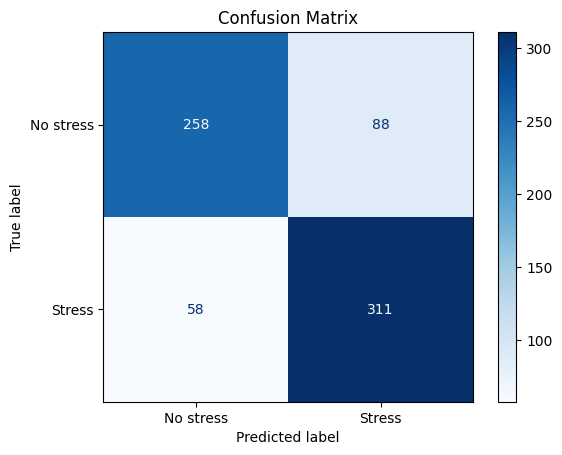

In [ ]:
id_to_label_map = {0: "No stress", 1: "Stress"}

y_preds = np.argmax(preds_outputs.predictions, axis=1)
y_true = [label for label in tokenized_test_df["label"]]
print(classification_report(y_true, y_preds, zero_division=0, target_names=id_to_label_map.values()))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(id_to_label_map.values()))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
# Conclusion: Precision, recall and f1-score are about the same for both stress and non-stress entries.
# The model does not bias by favouring one label more often than the other which is good.

### Analysis 1
A deep dive into the misclassified entries with the highest confidence in the wrong prediction.

In [ ]:
# Identify misclassified examples
misclassified_indices = [i for i, (true, pred) in enumerate(zip(y_true, y_preds)) if true != pred]
misclassified_reviews = [test_df["text"][i] for i in misclassified_indices]
misclassified_true_labels = [id_to_label_map[y_true[i]] for i in misclassified_indices]
misclassified_predicted_labels = [id_to_label_map[y_preds[i]] for i in misclassified_indices]

# Calculate softmax probabilities for model's confidence scores
probabilities = torch.nn.functional.softmax(torch.tensor(preds_outputs.predictions), dim=-1).numpy()
misclassified_model_confidences_predicted = [probabilities[i][y_preds[i]] for i in misclassified_indices]

# Get dataset's confidence and subreddit for the true label
misclassified_dataset_confidences_true = [test_df["confidence"][i] for i in misclassified_indices]
misclassified_dataset_subreddit = [test_df["subreddit"][i] for i in misclassified_indices]

# Combine all misclassified data into a DataFrame
misclassified_data = pd.DataFrame({
    'Review': misclassified_reviews,
    'True label': misclassified_true_labels,
    'Predicted label': misclassified_predicted_labels,
    'Dataset Confidence for true label': misclassified_dataset_confidences_true,
    'Model Confidence for predicted label': misclassified_model_confidences_predicted,
    'Subreddit': misclassified_dataset_subreddit
})

# Sort by model's confidence scores of predicted label in descending order
misclassified_data_sorted = misclassified_data.sort_values(by='Model Confidence for predicted label', ascending=False)

# Display only the top 5 misclassified examples with highest model confidence
print(f"Number of misclassified examples: {len(misclassified_indices)}")
print("\nTop 5 misclassified examples with highest model confidence:")
for i in range(min(5, len(misclassified_data_sorted))):
    row = misclassified_data_sorted.iloc[i]
    print(f"Review: {row['Review']}")
    print(f"True label: {row['True label']} (Dataset Confidence: {row['Dataset Confidence for true label']:.4f})")
    print(f"Predicted label: {row['Predicted label']} (Model Confidence: {row['Model Confidence for predicted label']:.4f})")
    print("-" * 50)

Number of misclassified examples: 146

Top 5 misclassified examples with highest model confidence:
Review: He is our little angel and we are both gaga for him, but money has been extraordinary tight, adjusting to parent life and sleep deprivation has been tough for both of us. We were fighting and bickering a bit for the first time in his first months of life, but I figured that was normal for new parents. I work in the financial industry for a modest income (working hard currently to get to the next level where I'll make substantially more) and she works for an arts-based nonprofit. I have no particular attachment to the financial industry, it's just been a way to pay the bills and I find it interesting enough. She's a passionate artist though, always knew she wanted to be one, and it's really important to her.
True label: Stress (Dataset Confidence: 0.6667)
Predicted label: No stress (Model Confidence: 0.9911)
--------------------------------------------------
Review: Maybe anyone wi

Firstly, we examine the misclassified entries with the highest confidence in the wrong predictions. We can observe that the model is about 99% confident in its prediction for these 5 entries, yet its prediction did not match the "true" label in the test dataset.

**Why does the model prediction not match the human labels?**
- Upon closer examination, it can be seen that the "true" labels for these misclassified entries are only approximately 60% confident, with one of the entries even having 0% confidence in its label. Given that the definition of the term "stress" is very subjective, it is not surprising that humans may disagree with the binary classification of "stress"--> "not stress" resulting in these low confidence scores. Hence, then we should also expect there will be times when humans will not agree with the model's predictions.

- It can also be seen that the model does not perform very well when the sentiment of the entry oscillates between positive and negative. This can be seen in entry number 1: "He is our little angel and we are both gaga for him (positive), but money has been extraordinary tight (negative)... We were fighting and bickering a bit for the first time in his first months of life (negative), but I figured that was normal for new parents (positive)..."
This is also true in entry number 2: "I tried to be supportive (positive) but obviously failed in the end here (negative). She's talking about wanting to divorce me (negative). We're looking into couples therapy (positive)."

### Analysis 2
Analysing the proportion of misclassified entries for different subreddits and identifying potential reasons.

In [ ]:
# Find proportion of misclassified instances from the various subreddits
total_subreddit = test_df['subreddit'].value_counts()
misclassified_subreddit_list = [test_df["subreddit"][i] for i in misclassified_indices]
misclassified_subreddit_counts = pd.Series(misclassified_subreddit_list).value_counts()
false_positives = []
false_negatives = []

for i in range(len(y_true)):
    true_label = y_true[i]
    predicted_label = y_preds[i]

    # Get raw logits for the current example
    logits = preds_outputs.predictions[i]

    # Convert logits to probabilities using softmax
    probabilities = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).cpu().numpy()

    # Get confidence for the predicted label
    confidence = probabilities[predicted_label]

    if true_label == 0 and predicted_label == 1:  # False Positive (predicted Stress, true No Stress)
        false_positives.append({"index": i, "true_label": true_label, "predicted_label": predicted_label, "confidence": confidence})
    elif true_label == 1 and predicted_label == 0:  # False Negative (predicted No Stress, true Stress)
        false_negatives.append({"index": i, "true_label": true_label, "predicted_label": predicted_label, "confidence": confidence})

false_positives.sort(key=lambda x: x["confidence"], reverse=True)
false_negatives.sort(key=lambda x: x["confidence"], reverse=True)


df1 = pd.concat([misclassified_subreddit_counts, total_subreddit], axis=1)
df1.columns = ['misclassified', 'total']
df1['misclassified_percentage'] = df1['misclassified'] / df1['total']

# Get subreddits for false positives and false negatives
fp_subreddits = [test_df['subreddit'][item['index']] for item in false_positives]
fn_subreddits = [test_df['subreddit'][item['index']] for item in false_negatives]

# Count false positives and false negatives per subreddit
fp_counts = pd.Series(fp_subreddits).value_counts()
fn_counts = pd.Series(fn_subreddits).value_counts()

# Join these counts to df1
df1 = df1.join(fp_counts.rename('false_positives')).fillna(0)
df1 = df1.join(fn_counts.rename('false_negatives')).fillna(0)

# Convert new columns to integer type
df1['false_positives'] = df1['false_positives'].astype(int)
df1['false_negatives'] = df1['false_negatives'].astype(int)

print(df1.sort_values(by='misclassified_percentage', ascending=False))

                  misclassified  total  misclassified_percentage  \
survivorsofabuse             19     70                  0.271429   
relationships                38    142                  0.267606   
almosthomeless                5     19                  0.263158   
stress                        3     14                  0.214286   
homeless                     11     52                  0.211538   
domesticviolence             14     72                  0.194444   
ptsd                         24    127                  0.188976   
anxiety                      25    147                  0.170068   
food_pantry                   1      6                  0.166667   
assistance                    6     66                  0.090909   

                  false_positives  false_negatives  
survivorsofabuse               13                6  
relationships                  21               17  
almosthomeless                  2                3  
stress                          1      

The "survivorsofabuse" subreddit has the greatest proportion of misclassified entries. It is also interesting that this subreddit has one of the most imbalanced proportion between false positives and false negatives misclassifications. We will explore the reason behind this imbalance.

In [ ]:
print("\n--- False Positive Entries for 'survivorsofabuse' Subreddit ---")
analysis_summary = []
subreddit_name = 'survivorsofabuse'

# Filter misclassified data for 'survivorsofabuse' and identify false positives
false_positives_for_subreddit = misclassified_data_sorted[
    (misclassified_data_sorted['Subreddit'] == subreddit_name) &
    (misclassified_data_sorted['True label'] == 'No stress') &
    (misclassified_data_sorted['Predicted label'] == 'Stress')
]

# Display these false positive entries
if not false_positives_for_subreddit.empty:
    for i in range(min(3, len(false_positives_for_subreddit))): # Display top 3 false positives
        row = false_positives_for_subreddit.iloc[i]
        print(f"\nEntry {i+1}:")
        print(f"Review: {row['Review']}")
        print(f"True label: {row['True label']} (Dataset Confidence: {row['Dataset Confidence for true label']:.4f})")
        print(f"Predicted label: {row['Predicted label']} (Model Confidence: {row['Model Confidence for predicted label']:.4f})")

        # Add insights for summary
        analysis_summary.append({
            'Subreddit': subreddit_name,
            'Review': row['Review'],
            'True label': row['True label'],
            'Predicted label': row['Predicted label'],
            'Model Confidence': row['Model Confidence for predicted label']
        })
else:
    print(f"No false positive entries found for '{subreddit_name}'.")


print("\n--- False Negative Entries for 'survivorsofabuse' Subreddit ---")

# Filter misclassified data for 'survivorsofabuse' and identify false negatives
false_negatives_for_subreddit = misclassified_data_sorted[
    (misclassified_data_sorted['Subreddit'] == subreddit_name) &
    (misclassified_data_sorted['True label'] == 'Stress') &
    (misclassified_data_sorted['Predicted label'] == 'No stress')
]

# Display these false negative entries
if not false_negatives_for_subreddit.empty:
    for i in range(min(3, len(false_negatives_for_subreddit))): # Display top 3 false negatives
        row = false_negatives_for_subreddit.iloc[i]
        print(f"\nEntry {i+1}:")
        print(f"Review: {row['Review']}")
        print(f"True label: {row['True label']} (Dataset Confidence: {row['Dataset Confidence for true label']:.4f})")
        print(f"Predicted label: {row['Predicted label']} (Model Confidence: {row['Model Confidence for predicted label']:.4f})")

        # Add insights for summary
        analysis_summary.append({
            'Subreddit': subreddit_name,
            'Review': row['Review'],
            'True label': row['True label'],
            'Predicted label': row['Predicted label'],
            'Model Confidence': row['Model Confidence for predicted label']
        })
else:
    print(f"No false negative entries found for '{subreddit_name}'.")


--- False Positive Entries for 'survivorsofabuse' Subreddit ---

Subreddit: survivorsofabuse

Entry 1:
Review: I sent a respectful email to my primary psychiatrist explaining my thoughts on how it was inappropriate to have Paterno's picture prominently displayed. Am I fucked up in the head for thinking this wrong? In the past, I had a mild traumatic brain injury. Sometimes I over react. 24 hours post appointment, I'm still bitter about the Paterno pics.
True label: No stress (Dataset Confidence: 0.0000)
Predicted label: Stress (Model Confidence: 0.9886)

Entry 2:
Review: I was never given a birthday party because it was inconvenient to have a bunch of kids over. In my pre-teen years I faced several years of having nothing and having to hide when someone knocked on the door because they were debt collectors or people who demanded payment for something. I faced the threat of homelessness, I faced abuse and horrible living conditions, I was bullied to the point of having to go to several

Based on the examples displayed, recurring patterns in misclassifications include:
1. **False Positives (True: No Stress, Predicted: Stress):** Often occur when entries contain strong negative keywords related to difficult life circumstances (e.g., 'abuse', 'homelessness', 'hospitals', 'addiction') even when the overall tone or context is in the long past and has been resolved, or contains elements of hope/gratitude. The model appears to overemphasize these negative terms without understanding that these negative feelings have been resolved and left in the past. (We have ignored entry 1 in the analysis since it has a confidence of 0% in its human label.)

2. **False Negatives (True: Stress, Predicted: No Stress):** Typically happen when texts expressing genuine stress or struggle are masked by initially positive framing, descriptive language, or a factual presentation of problems without highly emotional vocabulary. The model might be misled by these seemingly neutral or positive words and underweights the underlying stressors (e.g., 'money tight', 'sleep deprivation', 'fighting', 'struggle').

3. **Nuance in Language:** The model struggles with posts that have conflicting emotional cues or complex narratives where explicit emotional markers are sparse, and stress is implied rather than overtly stated.

One possible reason as to why the "survivorsofabuse" subreddit has the greatest percentage of misclassified entries could be precisely of the context "survivors". This subreddit mainly contain entries that describe experiences that happened long ago (e.g. contains words like 'back then', 'in 2015'), and we have established that the model is not very good at understanding the temporal aspect of the text.

### Analysis 3
Interpreting model predictions via SHAP.

In [ ]:
!pip install shap --quiet

In [ ]:
import shap

SHAP library imported successfully.


In [ ]:
representative_test_data = test_df['text'].sample(n=50, random_state=42).tolist()
print(f"Number of samples in representative test data: {len(representative_test_data)}")
print("First 5 samples:")
for i, sample in enumerate(representative_test_data[:5]):
    print(f"{i+1}. {sample[:100]}...")

Number of samples in representative test data: 50
First 5 samples:
1. <url> To learn more about what my disabilities are like for me, you can read this post. <url> in it ...
2. I just wanted to be believed. She said that she would talk to toe - A few days later she came back t...
3. The server encourages happiness and improving yourself. Glamorizing mental illnesses and encouraging...
4. Has anyone dealt with urinary retention as a side effect of lexapro? I've been taking lexapro for li...
5. CW: mentions of self-harm, suicide I feel so overwhelmed. The flashbacks, the panic attacks, being t...


In [ ]:
def predict_proba(texts):
    # Tokenize the input texts
    tokenized_inputs = tokenizer(texts, truncation=True, padding=True, return_tensors="pt")

    # Move inputs to the device the model is on
    input_ids = tokenized_inputs['input_ids'].to(device)
    attention_mask = tokenized_inputs['attention_mask'].to(device)

    # Make predictions
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    # Apply softmax to get probabilities
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()

    # Return probabilities. The second column corresponds to the 'Stress' label (1).
    # The first column corresponds to 'No stress' (0).
    return probabilities

# Test the prediction function with a sample from the representative_test_data
sample_text = representative_test_data[0]
print(f"Sample text: {sample_text[:100]}...")
probabilities = predict_proba([sample_text])

print(f"Predicted probabilities: {probabilities}")
print(f"Probability of 'No stress': {probabilities[0][0]:.4f}")
print(f"Probability of 'Stress': {probabilities[0][1]:.4f}")
print("Prediction function defined and tested successfully.")

Sample text: <url> To learn more about what my disabilities are like for me, you can read this post. <url> in it ...
Predicted probabilities: [[0.62940454 0.37059546]]
Probability of 'No stress': 0.6294
Probability of 'Stress': 0.3706
Prediction function defined and tested successfully.


In [ ]:
def predict_proba(texts):
    # Ensure texts is always a list of strings, even if a single string or numpy array is passed
    if isinstance(texts, str):
        texts = [texts]
    elif isinstance(texts, np.ndarray): # Handle numpy array of strings
        texts = texts.tolist()

    # Tokenize the input texts
    tokenized_inputs = tokenizer(texts, truncation=True, padding=True, return_tensors="pt")

    # Move inputs to the device the model is on
    input_ids = tokenized_inputs['input_ids'].to(device)
    attention_mask = tokenized_inputs['attention_mask'].to(device)

    # Make predictions
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    # Apply softmax to get probabilities
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()

    # Return probabilities. The second column corresponds to the 'Stress' label (1).
    # The first column corresponds to 'No stress' (0).
    return probabilities

# Test the prediction function with a sample from the representative_test_data
sample_text = representative_test_data[0]
print(f"Sample text: {sample_text[:100]}...")
probabilities = predict_proba([sample_text])

print(f"Predicted probabilities: {probabilities}")
print(f"Probability of 'No stress': {probabilities[0][0]:.4f}")
print(f"Probability of 'Stress': {probabilities[0][1]:.4f}")

Sample text: <url> To learn more about what my disabilities are like for me, you can read this post. <url> in it ...
Predicted probabilities: [[0.62940454 0.37059546]]
Probability of 'No stress': 0.6294
Probability of 'Stress': 0.3706
Prediction function defined and tested successfully.


In [ ]:
masker = shap.maskers.Text(tokenizer=tokenizer, mask_token=tokenizer.pad_token if tokenizer.pad_token else "[PAD]")

# Initialize explainer with the predict_proba function and the text masker
# predict_proba takes raw text, and masker.Text will ensure it gets raw text.
explainer = shap.PartitionExplainer(predict_proba, masker, output_idx=1) # output_idx=1 for 'Stress' class

# Compute SHAP values for the representative test data
# This might take a while depending on the number of samples and text length
shap_values = explainer(representative_test_data)

print("SHAP explainer initialized and SHAP values computed successfully.")

PartitionExplainer explainer: 51it [01:02,  1.26s/it]

SHAP explainer initialized and SHAP values computed successfully.


Visualizing SHAP values for an individual prediction (first sample):



Visualizing overall feature importance (bar plot):


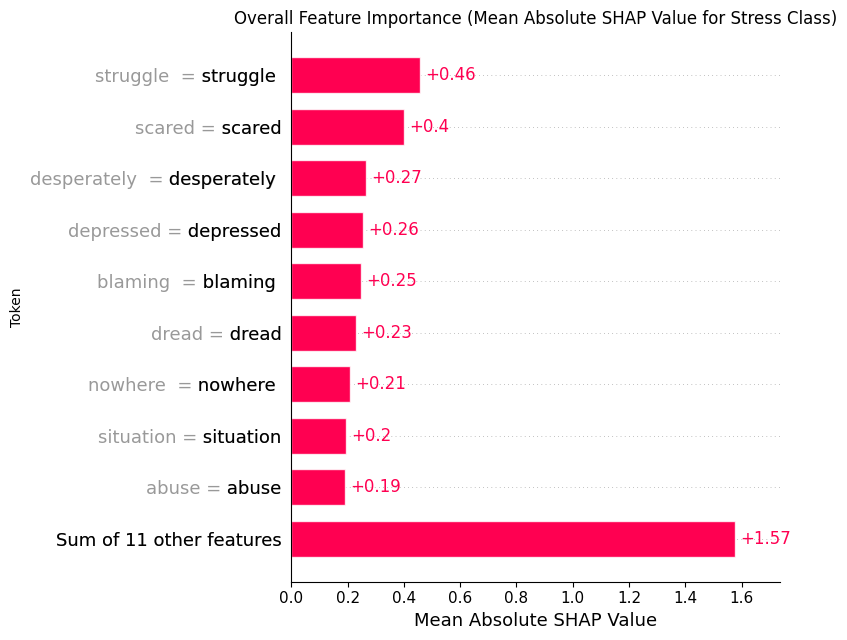

In [ ]:
print("Visualizing SHAP values for an individual prediction (first sample):")
shap.plots.text(shap_values[0])

print("\nVisualizing overall feature importance (bar plot):")

# Aggregate SHAP values to compute overall feature importance for unique tokens
all_tokens = []
all_shap_values_for_class_1_flat = []

# Flatten the list of tokens and SHAP values from all samples
for i in range(len(shap_values.data)):
    sample_tokens = shap_values.data[i].tolist() if isinstance(shap_values.data[i], np.ndarray) else shap_values.data[i]
    sample_shap_raw = shap_values.values[i]

    # Ensure shap_val is a single float for the target class (index 1)
    if sample_shap_raw.ndim == 1: # If already a 1D array of SHAP values for the target class
        sample_shap_for_class_1 = sample_shap_raw.tolist()
    elif sample_shap_raw.ndim == 2: # If (num_tokens, num_classes)
        sample_shap_for_class_1 = sample_shap_raw[:, 1].tolist()
    else:
        raise ValueError(f"Unexpected shape for shap_values.values[{i}]: {sample_shap_raw.shape}")

    all_tokens.extend(sample_tokens)
    all_shap_values_for_class_1_flat.extend(sample_shap_for_class_1)

# Create a dictionary to sum absolute SHAP values and count occurrences for each unique token
token_importance = {}
token_counts = {}

for token, shap_val in zip(all_tokens, all_shap_values_for_class_1_flat):
    token_str = str(token)
    # Exclude padding tokens, empty strings, or None values from consideration
    if token_str == tokenizer.pad_token or token_str is None or token_str == "":
        continue
    token_importance[token_str] = token_importance.get(token_str, 0) + abs(shap_val)
    token_counts[token_str] = token_counts.get(token_str, 0) + 1

# Calculate average absolute SHAP value for each unique token
average_abs_shap_values = {
    token: total_abs_shap / token_counts[token]
    for token, total_abs_shap in token_importance.items()
}

# Sort tokens by their average absolute SHAP value in descending order
sorted_token_importance = sorted(average_abs_shap_values.items(), key=lambda item: item[1], reverse=True)

# Extract top N features and their importance for plotting
top_n_features = 20  # You can adjust this number
top_feature_names = [item[0] for item in sorted_token_importance[:top_n_features]]
top_feature_values = [item[1] for item in sorted_token_importance[:top_n_features]]

# Create a SHAP Explanation object for the bar plot
# shap.Explanation requires `values`, `base_values`, and `data`.
# For a global feature importance plot, `base_values` can be set to 0 or average, and `data` can be `top_feature_names`.
# However, shap.plots.bar can also directly take values and feature_names if wrapped in an Explanation object.
# A simpler way for global feature importance is to create a dummy Explanation object.

dummy_explanation = shap.Explanation(
    values=np.array(top_feature_values),
    base_values=0, # Base value is not critical for simple bar plots of importance
    data=np.array(top_feature_names), # Data is typically the feature values, but for text, feature names work.
    feature_names=top_feature_names
)

# Display the bar plot using shap.plots.bar with the dummy Explanation object
plt.figure(figsize=(10, 6))
shap.plots.bar(dummy_explanation, show=False) # Set show=False to handle figure manually
plt.title('Overall Feature Importance (Mean Absolute SHAP Value for Stress Class)')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Token')
plt.tight_layout()
plt.show()

The bar plot displays the Mean Absolute SHAP Value for various tokens (words). The larger the bar, the more influence that specific word has on the model’s prediction that a text belongs to the "Stress" class.
We observe emotionally charged words like "struggle", "scared", "depressed" and more are strongly associated with the reason behind the model's prediction to be stress. This is consistent with our previous analysis.

### Discussion of model deployment

This model takes a Reddit post made by a user and predicts whether the user who made that post is feeling stressed or not stressed. In a real-world scenario, this model may be deployed in Singapore to analyse text data from social media sites (for example NUSConfessit Reddit), the prediction made by the model could be used as a preliminary detection system to identify students who may potentially need mental heath support and direct them to support helplines.

When deploying the model into society there are several risks to consider:

- Prediction of False Negatives. This means the model predicts the person to be not stressed when the person is actually feeling stressed. False Negatives are more costly than other errors because missing early warning signals could result in the stressed individual in question to not receive the proper mental healthcare. One possible mitigation then could be to prioritise minimising False Negatives when building the model by maximizing metrics such as recall.

- Violation of privacy. Some users may not feel comfortable having their posts analyzed by an AI and given the label of being stressed or not stressed. Psychological profiling is not something everyone is comfortable with. One possible mitigation is to let the user know their posts may be used in this model and be transparent in how their data is used and how the model works while guaranteeing anonymity.

- The model may be biased. The Dreaddit dataset used to finetune the model comes from Reddit and the users there may not be representative of all communities (in this case, students). The model may not generalize well to the Singaporean context and other social platforms. The model also may not be able to understand slang such as Singlish and other Singaporean cultures, which increases the likelihood of a wrong prediction. One mitigation perhaps could be to finetune the model using data from Singaporean students so that model is given proper context.